# Still needing to do list:


* Someone to look over the code I have done so far and check for any mistakes! Particularly with the model fitting to obtain the zero-point magnitude and extinction coefficients.
* Errors for the zero-point magntidue and extinction coefficient (just used the code from obsastro last year so I didn't really put any thought into it. it needs to be done properly!)
* Plot a graph for the parameter uncertainties obtained from the model fit function? (see workshop 4, slide 17/18)
* Dust extinction??? Does these calculations affect our values and errors for the final calibrated magnitude of WASP or it is just extra information we state alongside it?
* -> Does this affect colour excess? Do we need to calcualte colour excess?
* Calculate colours for WASP (i've already done B-V)
* Calculate errors for colours for WASP (not even started or thought about yet)
* Calcualte the curve of growth for each standard star (the aperture might change for each standard star??)

# Import packages

Different packages used:

* matplotlib.pyplot
* matplotlib.colors
* numpy
* astropy.io
* astropy.stats
* glob??
* os??
* photometryExercise
* photutils.aperture
* photutils.detection
* photometryExercise
* scipy.optimize

Write a description of each of these packages and the functions used?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
from photometryExercise import standardPlot
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from photutils.detection import DAOStarFinder
from photometryExercise import standardPlot
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

In [2]:
from bokeh.io import show, output_notebook
# set local host for bokeh (change the number to the one in the url at the top of the page)
localhost = 'localhost:8888'

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.


# Defining functions

In [5]:
def show_fits(data, title=""):
    """
    stolen from the obs astro code but like the backend code they wrote which we didn't see
    """
    plt.figure(figsize=(8, 8))
    
    # Use ZScale for astronomical images
    interval = ZScaleInterval()
    vmin, vmax = interval.get_limits(data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())
    
    plt.imshow(data, origin='lower', cmap='gray', norm=norm)
    plt.colorbar(label='Counts')
    plt.title(title)
    print(f"{title}: min={np.min(data):.1f}, max={np.max(data):.1f}, median={np.median(data):.1f}")
    print(f"Display range (ZScale): {vmin:.1f} to {vmax:.1f}")
    plt.show()
    
trim = 50  # idk what this should be lol

In [6]:
def flux_to_mag(C):
    """
    Calculates the apparent magnitude from the total flux.

    Parameters
    ---
    C : float or array_like
        The total flux or counts. This value must be positive

    Returns
    ---
    float or array_like
        The calcualted apparents magnitude. Returns np.nan if the input C is non-positive
    """

    # check if the counts are negative
    if C <= 0:
        print("Counts are non-positive")
        return np.nan
        
    return - 2.5 * np.log10(C)

In [7]:
def error_in_mag(C, s):
    """
    Estimates the error in the apparent mangitude measurement based on Poisson statistics.

    Parameters
    ----------
    C : float or array_like
        Net counts (or flux) from the object (C_object). This must be positive.
    s : float or array_like
        Total counts (or flux) measured from the sky background within the 
        same aperture area (C_sky). Must be non-negative.

    Returns
    -------
    float or array_like
        The estimated 1-sigma uncertainty (error) in the apparent magnitude (Δm).
        Returns np.nan if the net object counts (C) is non-positive.
    """

    # calculate the total counts within the aperture t
    t = C + s

    # calculate the final area of the objects counts by summing in quadrature of the errors
    del_C = np.sqrt(t + s)

    # calculate and return the magnitude error
    return - 2.5 / np.log(10) * (del_C / C)

In [8]:
def instrumental_magnitudes(f, xcor, ycor, rAperture=5):
    """
    Performs aperture photometry on an astronomical image (FITS file) to obtain 
    the net instrumental magnitude and its associated error for a single source.

    The sky background is estimated using a surrounding annulus and subtracted 
    from the total flux within the object aperture.

    Parameters
    ----------
    f : str
        The filepath of the FITS file containing the astronomical image data.
    xcor : float
        The x-coordinate of the source centroid.
    ycor : float
        The y-coordinate of the source centroid.
    rAperture : int, optional
        The radius of the circular aperture in pixels. Default is 5.

    Returns
    -------
    tuple
        A tuple containing:
        1. instrumental_magnitude (float): The calculated instrumental magnitude.
        2. instrumental_magnitude_error (float): The estimated 1-sigma error on 
           the instrumental magnitude.
    """

    standard = fits.open(f)[0].data

    # create the ciruclar aperture and sky annulus
    rSkyInner = 1.5 * rAperture
    rSkyOuter = 2 * rAperture

    apertureStandard = CircularAperture((xcor, ycor), r=rAperture)
    annulusSky = CircularAnnulus((xcor, ycor), r_in=rSkyInner, r_out=rSkyOuter)

    # make an estimation of the sky values in the defined annulus
    # aperture_photometry returns an astropy.table with the center of the aperture and 
    # the total flux on the aperture ('aperture_sum')
    sky = aperture_photometry(standard, annulusSky)
    #print(sky)

    # to recover the mean sky value, weight the total flux by the area of the annulus
    area = np.pi * (rSkyOuter ** 2 - rSkyInner **2)
    skyFlux = sky['aperture_sum'].value[0]
    meanSkyValue = skyFlux / area
    #print(f'The sky flux is {skyFlux}')
    #print(f'The mean sky value is {meanSkyValue}')

    # remove the sky value
    standard = aperture_photometry(standard - meanSkyValue, apertureStandard)

    # extract value from astropy.table
    standardFlux = standard['aperture_sum'].value[0]
    #print(f'The total flux on aperture is {standardFlux}')

    # calculating instrumental magnitude and its errors and append to list
    instrumental_magnitude = flux_to_mag(standardFlux)
    instrumental_magnitude_error = error_in_mag(standardFlux, skyFlux)

    return instrumental_magnitude, instrumental_magnitude_error

In [9]:
def airmasses(f):
    """
    Calculates the airmass (X) of an observation using the plane-parallel 
    atmosphere approximation: X = 1 / cos(z), where z is the zenith angle.

    It extracts the 'ALTITUDE' of the observation from the FITS file header 
    and converts it to the zenith angle (z = 90 - Altitude).

    Parameters
    ----------
    f : str
        The filepath of the FITS file containing the astronomical image. 
        The primary header (HDU 0) must contain a keyword 'ALTITUDE' 
        (in degrees).

    Returns
    -------
    float
        The calculated airmass of the observation. Returns np.nan if the 
        FITS file cannot be read or the ALTITUDE keyword is missing.
    """

    with fits.open(f) as hdul:
        header = hdul[0].header

    altitude = header['ALTITUDE']
    #print(f"the altitude is {altitude}")
    zenith_angle = 90.0 - altitude
    #print(f"the zenith angle is {zenith_angle}")

    # convert to radians
    zenith_angle_rad = np.deg2rad(zenith_angle)

    # calcualte airmass
    airmass = 1.0 / np.cos(zenith_angle_rad)
    #print(f"the airmass is {airmass}")

    return airmass

In [10]:
def coordinates(f, xcor, ycor, aperture_radius = 5, sigma = 3.0, fwhm = 3.0):
    """
    Finds the precise (x, y) coordinates of the star closest to the initial 
    guess (xcor, ycor) by using DAOStarFinder for accurate centroiding.

    This function is crucial for high-precision photometry as it corrects for 
    slight drifts or errors in telescope pointing.

    Parameters
    ----------
    f : str
        The filepath of the FITS file containing the astronomical image data.
    xcor : float
        The initial estimated x-coordinate (guess) for the star's position.
    ycor : float
        The initial estimated y-coordinate (guess) for the star's position.
    aperture_radius : int, optional
        The radius to be used for a potential aperture (used for context, not
        used for calculation in this function, default is 5).
    sigma : float, optional
        The sigma clipping level used for background estimation (sigma_clipped_stats). 
        Default is 3.0.
    fwhm : float, optional
        The full width at half maximum of the stellar profile in pixels, used 
        by DAOStarFinder. Default is 3.0.

    Returns
    -------
    tuple (float, float)
        The refined (x, y) centroid coordinates of the star closest to the guess.
        Returns (np.nan, np.nan) if the file cannot be read or no stars are found.
    """

    # open data
    hdul = fits.open(f)
    image_data = hdul[0].data

    # Detect stars in this image
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*std)
    sources = daofind(image_data - median)

    # Find the detected star closest to your expected position
    distances = np.sqrt((sources['xcentroid'] - xcor)**2 + (sources['ycentroid'] - ycor)**2)
    idx = np.argmin(distances)
    star_pos = (sources['xcentroid'][idx], sources['ycentroid'][idx])

    # Photometry at the detected position
    #aperture = CircularAperture(star_pos, r=aperture_radius)
    #aperstats = ApertureStats(image_data, aperture)
    hdul.close()

    return star_pos

In [11]:
def star_location_plot(f, xcor, ycor, xmin=700, xmax=1200, ymin=700, ymax=1200):
    """
    Plots the image data, zooms in on a specified region, and highlights all 
    detected stars, with the target star marked in red.

    This function is used for visually confirming the centroiding accuracy.

    Parameters
    ----------
    f : str
        The filepath of the FITS file containing the astronomical image data.
    xcor : float
        The initial estimated x-coordinate (guess) for the star's position.
    ycor : float
        The initial estimated y-coordinate (guess) for the star's position.
    xmin, xmax, ymin, ymax : int, optional
        The pixel boundaries for the zoomed-in plot view (default: 700 to 1200).
    """

    fwhm = 3.0
    sigma = 3.0

    # open data
    hdul = fits.open(f)
    image_data = hdul[0].data

    # Detect stars in this image
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*std)
    sources = daofind(image_data - median)

    # Find the detected star closest to your expected position
    distances = np.sqrt((sources['xcentroid'] - xcor)**2 + (sources['ycentroid'] - ycor)**2)
    idx = np.argmin(distances)
    star_pos = (sources['xcentroid'][idx], sources['ycentroid'][idx])

    x2 = 98
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=6)
    plt.figure()
    plt.imshow(image_data, origin='lower', norm=LogNorm(vmin=np.median(image_data), vmax=np.percentile(image_data, x2)), interpolation='nearest')
    apertures.plot(color='blue', lw=1.0, alpha=0.5)

    target_aperture = CircularAperture(star_pos, r=6)
    target_aperture.plot(color='red', lw=1.0, alpha=0.5) # Use a slightly thicker line (lw=2.5) for visibility
    
    plt.xlim(700, 1200)  # x-axis pixel range
    plt.ylim(700, 1200)  # y-axis pixel range
    
    print(f, star_pos[0], star_pos[1])
    
    plt.show()

    return star_pos[0], star_pos[1]

In [133]:
# write a function to calculate the obtain all values of a certain filter
def filter_ins_mag_vs_airmass(filter, print_values=False):
    """
    Returns the instrumental magnitudes, combined error, and airmasses
    for all standard stars for a specific filter.

    Parameters
    ----------
    filter : str
        The photometric filter band ('B', 'I', 'R', or 'V').

    Returns
    -------
    tuple of (list, list, list)
        (ins_mag_list, ins_mag_err_list, airmass_list)
        Each list contains multiple (3) values per standard star (12 values total).
    """

    # create empty lists to store data
    ins_mags = []
    ins_mags_err = []
    airmasses = []   
    airmasses_err = []

    # Determine the index slice for the filter
    if filter == 'B':
        start_idx, end_idx = 0, 3
    elif filter == 'I':
        start_idx, end_idx = 3, 6
    elif filter == 'R':
        start_idx, end_idx = 6, 9
    elif filter == 'V':
        start_idx, end_idx = 9, 12
    else:
        # If the filter is not recognized, return empty lists
        print(f"Filter '{filter}' not recognized.")
        return [], []

    # iterate through all four standard stars
    for i in range(0,4):

        # take the values for a standard star
        ins_m = stars_ins_mag[i]
        ins_m_err = stars_ins_mag_err[i]
        airm = stars_airmass[i]

        # mean of the instrumental magnitude and airmass for the defined filter
        mean_ins_mag = np.mean(ins_m[start_idx:end_idx])
        mean_airmass = np.mean(airm[start_idx:end_idx])

        # uncertainty calculations
        # airmass will have a standard deviation on the mean
        mean_airmasses_err = np.std(airm[start_idx:end_idx]) / np.sqrt(3)
        
        # instrumental magnitude will have a random error from the counts and systematic error
        random_ins_mag_err = ins_m_err[start_idx:end_idx] # this is the random errors from the counts
        mean_random_ins_mag_err = np.sqrt(random_ins_mag_err[0]**2 + random_ins_mag_err[1]**2 + random_ins_mag_err[2]**2)
    
        systematic_ins_mag_err = np.std(ins_m[start_idx:end_idx]) #* np.sqrt(3) # this is the systematic error
        
        #total_ins_mag_err = np.sqrt(mean_random_ins_mag_err**2 
         #                         + systematic_ins_mag_err**2) # add the random and systematic errors in quadrature
        total_ins_mag_err = systematic_ins_mag_err

        if print_values==True:
            # print values to check
            print(f"star: {i+1}")
            print(f"mean instrumental magnitude: {mean_ins_mag} ± {total_ins_mag_err}")
            print(f"mean airmass: {mean_airmass} ± {mean_airmasses_err}")
            print(f"instrumental magnitude random errors: {random_ins_mag_err}")
            print(f"instrumental magnitude total random errors: {mean_random_ins_mag_err}")
            print(f"instrumental magnitude systematic errors: {systematic_ins_mag_err}")

        # append values to the lists
        ins_mags.append(mean_ins_mag)
        ins_mags_err.append(total_ins_mag_err)
        airmasses.append(mean_airmass)
        airmasses_err.append(mean_airmasses_err)

    return ins_mags, ins_mags_err, airmasses, airmasses_err

In [132]:
# write a function to calculate the obtain all values of a certain filter for wasp
def wasp_filter_ins_mag_vs_airmass(filter, print_values=False):
    """
    Returns the instrumental magnitudes, combined error, and airmasses
    for all standard stars for a specific filter.

    Parameters
    ----------
    filter : str
        The photometric filter band ('B', 'I', 'R', or 'V').

    Returns
    -------
    tuple of (list, list, list)
        (ins_mag_list, ins_mag_err_list, airmass_list)
        Each list contains multiple (3) values per standard star (12 values total).
    """

    # create empty lists to store data
    ins_mags = []
    ins_mags_err = []
    airmasses = []   
    airmasses_err = []

    # Determine the index slice for the filter
    if filter == 'B':
        start_idx, end_idx = 0, 3
    elif filter == 'I':
        start_idx, end_idx = 3, 6
    elif filter == 'R':
        start_idx, end_idx = 6, 9
    elif filter == 'V':
        start_idx, end_idx = 9, 12
    else:
        # If the filter is not recognized, return empty lists
        print(f"Filter '{filter}' not recognized.")
        return [], []

    # mean of the instrumental magnitude and airmass for the defined filter
    mean_ins_mag = np.mean(target_ins_mags[start_idx:end_idx])
    mean_airmass = np.mean(target_airmasses[start_idx:end_idx])

    # uncertainty calculations
    # airmass will have a standard deviation on the mean
    mean_airmasses_err = np.std(target_airmasses[start_idx:end_idx]) / np.sqrt(3)

    # instrumental magnitude will have a random error from the counts and systematic error
    random_ins_mag_err = target_ins_mag_errs[start_idx:end_idx] # this is the random errors from the counts
    mean_random_ins_mag_err = np.sqrt(random_ins_mag_err[0]**2 + random_ins_mag_err[1]**2 + random_ins_mag_err[2]**2)
    
    systematic_ins_mag_err = np.std(target_ins_mags[start_idx:end_idx]) #* np.sqrt(3) # this is the systematic error
    #total_ins_mag_err = np.sqrt(mean_random_ins_mag_err**2 
    #                          + systematic_ins_mag_err**2) # add the random and systematic errors in quadrature
    total_ins_mag_err = systematic_ins_mag_err

    if print_values==True:
        # print values to check
        print(f"mean instrumental magnitude: {mean_ins_mag} ± {total_ins_mag_err}")
        print(f"mean airmass: {mean_airmasses_err} ± {mean_airmasses_err}")
        print(f"instrumental magnitude random errors: {random_ins_mag_err}")
        print(f"instrumental magnitude total random errors: {mean_random_ins_mag_err}")
        print(f"instrumental magnitude systematic errors: {systematic_ins_mag_err}")

    # append values to the lists
    ins_mags.append(mean_ins_mag)
    ins_mags_err.append(total_ins_mag_err)
    airmasses.append(mean_airmass)
    airmasses_err.append(mean_airmasses_err)

    return ins_mags, ins_mags_err, airmasses, airmasses_err

In [134]:
def model(x, a, b):
    """
    Linear model function for atmospheric extinction correction, typically
    used with scipy.optimize.curve_fit.

    This function represents the observed instrumental magnitude (m) as a
    linear function of air mass (X), based on the standard extinction equation:
    m = m_0 + k * X

    The modeled relationship is: y = b - a * x, where:
    - x corresponds to the air mass (X)
    - b corresponds to the zero-airmass, or "exo-atmospheric," magnitude (m_0)
    - -a corresponds to the first-order extinction coefficient (k)

    Parameters
    ----------
    x : array-like
        The independent variable, typically the **Air Mass (X)**, which is
        often approximated by sec(zenith_distance).
    a : float
        The first fitting parameter, representing the **negative of the
        extinction coefficient (-k)** in magnitudes per air mass.
    b : float
        The second fitting parameter, representing the **zero-airmass magnitude (m_0)**
        of the celestial object.

    Returns
    -------
    array-like
        The modeled dependent variable, representing the **instrumental magnitude (m)**
        at the given air mass(es) x.
    """
    return b - a * x

In [135]:
def perform_extinction_correction(magnitudes, airmasses, magnitude_errors, airmass_errors, filter_name, print_text=True, same_axis_scale = True, yerr_best_fit = True, abs_sigma = True):
    """
    Performs a linear fit to observational data (magnitude vs. airmass)
    to determine the atmospheric extinction coefficient and the zero-point
    magnitude. It uses scipy.optimize.curve_fit, including
    magnitude uncertainties for weighted fitting, and generates a scatter plot
    of the data with the best-fit line.

    The fit uses the model: magnitude = m_0 - k * X, where X is the airmass.

    Parameters
    ----------
    magnitudes : array-like
        Observed instrumental magnitudes (y-data) of the celestial object
        at different times.
    airmasses : array-like
        The corresponding Air Mass (X) values (x-data) for each observation,
        typically sec(zenith_distance).
    magnitude_errors : array-like
        The observational uncertainty (standard error) associated with each
        instrumental magnitude measurement. These are used as 'sigma' in
        curve_fit for weighted fitting.
    filter_name : str
        The name of the photometric filter (e.g., 'V', 'R', 'B') to be
        used in the plot title and output printout.

    Returns
    -------
    tuple
        A tuple containing the four fitted parameters and their standard errors:
        (a_fit, a_error, b_fit, b_error), where:
        - a_fit: The negative of the extinction coefficient (-k).
        - a_error: The standard error of a_fit.
        - b_fit: The zero-airmass magnitude (m_0).
        - b_error: The standard error of b_fit.

    Notes
    -----
    The function prints the calculated Extinction Coefficient (k = -a_fit)
    and the Zero-Point Magnitude (m_0 = b_fit) with their respective errors.
    It relies on a separate function 'model' and the 'numpy', 'matplotlib.pyplot',
    and 'scipy.optimize.curve_fit' packages.
    """

    # make sure the errors are positive
    magnitude_errors = np.abs(magnitude_errors)
    
    # Fit the model to the data
    if yerr_best_fit==True:
        params, covariance = curve_fit(model, airmasses, magnitudes, sigma = magnitude_errors, absolute_sigma = abs_sigma)
    else:
        params, covariance = curve_fit(model, airmasses, magnitudes) 
    
    # Extract the fitted parameters
    a_fit, b_fit = params
    cov_matrix = covariance
    
    # Calculate the parameter errors
    a_error = np.sqrt(cov_matrix[0, 0])  
    b_error = np.sqrt(cov_matrix[1, 1])  

    # Create the fitted curve
    x_fit = np.linspace(min(airmasses), max(airmasses), 100)
    y_fit = model(x_fit, *params)
    
    # Plot the data and the fitted line
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Increased marker and line sizes for visibility
    ax.plot(x_fit, y_fit, label="Best fit function", color='red', linewidth=2)
    ax.errorbar(airmasses, magnitudes, yerr=magnitude_errors, xerr=airmass_errors, fmt='o', label="Data", capsize=3, markersize=7)

    # 1. INCREASE TICK SIZE (The numbers on the axes)
    ax.tick_params(axis='both', which='major', labelsize=22)

    # 2. INCREASE LABEL SIZE (Using your exact LaTeX strings)
    ax.set_xlabel(r'Airmass ($\sec \theta$)', fontsize=22)
    ax.set_ylabel(r'$m_{\text{true}} - m_{\text{obs}}$', fontsize=22)
    
    # 3. INCREASE TITLE SIZE (Using your exact title format)
    ax.set_title(f'Airmass $\sec(\\theta)$ vs ($m_{{\\text{{true}}}}$ - $m_{{\\text{{obs}}}}$) for {filter_name} Filter', fontsize=24, pad=20)

    if print_text==True:
        mean_y = np.mean(magnitudes)
        if mean_y > 20.6:
            y_pos = 0.05
            va = 'bottom'
        else:
            y_pos = 0.95
            va = 'top'

        # 4. INCREASE TEXT BOX FONT SIZE
        text_content = (r'Extinction Coeff. ($k$): ' + f'${a_fit:.4f} \pm {a_error:.4f}$\n' +
                        r'Zero-Point Mag. ($m_0$): ' + f'${b_fit:.4f} \pm {b_error:.4f}$')

        ax.text(0.05, y_pos, text_content, 
                transform=ax.transAxes,
                fontsize=18, # Increased from 12
                verticalalignment=va,
                horizontalalignment='left',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8, ec="gray"))

    # 5. INCREASE LEGEND SIZE
    ax.legend(loc='best', fontsize=16)

    if same_axis_scale==True:
        ax.set_ylim(19.75, 21.5)
    
    plt.tight_layout() # Prevents larger labels from being cut off
    plt.show()

    # RESTORED: Call the uncertainty plotting function
    plot_uncertainty_ellipses(params, cov_matrix, filter_name)

    return a_fit, a_error, b_fit, b_error

In [16]:
def get_ellipse_geometry(cov):
    """Calculates the width, height, and rotation angle from a covariance matrix."""
    vals, vecs = np.linalg.eigh(cov)
    # Sort eigenvalues in descending order
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    # Calculate the rotation angle in degrees
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    return vals, theta

In [320]:
def plot_uncertainty_ellipses(params, cov_matrix, filter_name):
    k_mid, m0_mid = params
    vals, theta = get_ellipse_geometry(cov_matrix)
    
    fig, ax = plt.subplots(figsize=(8, 8)) # Slightly larger for readability
    
    # Define 1, 2, and 3 sigma levels
    for sigma, color in zip([1, 2, 3], ['#444444', '#888888', '#CCCCCC']):
        # Width and height are 2 * sigma * sqrt(eigenvalue)
        width, height = 2 * sigma * np.sqrt(vals)
        
        ell = Ellipse(xy=(k_mid, m0_mid), width=width, height=height, 
                      angle=theta, edgecolor=color, fc='none', lw=2.0, 
                      label=f'${sigma}\sigma$')
        ax.add_patch(ell)

    ax.scatter(k_mid, m0_mid, c='black', zorder=5, s=50) # Increased marker size

    # 1. READABLE TICK SIZES
    ax.tick_params(axis='both', which='major', labelsize=22)

    # 2. READABLE AXIS LABELS
    ax.set_xlabel(r'$k_{\lambda}$', fontsize=22, labelpad=10)
    ax.set_ylabel(r'$m_{ZP, \text{airmass}=1}$', fontsize=22, labelpad=10)
    
    # 3. READABLE TITLE
    ax.set_title(f'Correlated uncertainties: {filter_name} Filter', fontsize=24, pad=20)
    
    # Auto-scale the view
    margin = 4 * np.sqrt(max(vals))
    ax.set_xlim(k_mid - margin, k_mid + margin)
    ax.set_ylim(m0_mid - margin, m0_mid + margin)
    
    # 4. READABLE LEGEND
    ax.legend(fontsize=14, loc='upper right')
    
    plt.tight_layout() # Ensures everything fits within the saved image
    plt.show()

# Set path directorys for data

In [18]:
# path settings
BASE_DIR = "data"

# standard stars + target fits files
STANDARD_DIR = os.path.join(BASE_DIR, "standards")

# individual standard stars + target
STAR1 = os.path.join(STANDARD_DIR, "star1")
STAR2 = os.path.join(STANDARD_DIR, "star2")
STAR3 = os.path.join(STANDARD_DIR, "star3")
STAR4 = os.path.join(STANDARD_DIR, "star4")
TARGET = os.path.join(STANDARD_DIR, "target")

# retrieving the data from the folders
star1_files = sorted(glob.glob(os.path.join(STAR1, "*.fits")))
star2_files = sorted(glob.glob(os.path.join(STAR2, "*.fits")))
star3_files = sorted(glob.glob(os.path.join(STAR3, "*.fits")))
star4_files = sorted(glob.glob(os.path.join(STAR4, "*.fits")))
target_files = sorted(glob.glob(os.path.join(TARGET, "*.fits")))

# Find coordinates for standards

Printed out the images for each star using the standardPlot function to zoom in and identify the star in the images,
manually obtaining the x- and y-coordinates.

This was intially done for the first image of each star.

Unhash the correct line in the codes to run it.

In [19]:
# find coordinates for star 1
with fits.open(star1_files[3]) as hdul:
    #print(star1_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [20]:
# find coordinates for star 2
with fits.open(star2_files[0]) as hdul:
    #print(star2_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [21]:
# find coordinates for star 3
with fits.open(star3_files[0]) as hdul:
    #print(star3_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [22]:
# find coordinates for star 4
with fits.open(star4_files[0]) as hdul:
    #print(star4_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [23]:
# find coordinates for wasp135b
with fits.open(target_files[0]) as hdul:
    #print(target_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

# Check the identified star is correct

Using the manually created star_location_plot (which uses DOAStarFinder), input starting point x- and y-coordinates
(which were found and noted down using the code above)
and the function will "follow" the star as its position slightly changes in each image.

This is just to confirm that the identified star and the coordinates are correct.

Unhash the correct lines in the codes to run it. 
(it takes a while)

In [318]:
# unhash to print out the locations of star1 images

# for the B filter
#for f in star1_files[:3]:
#    star_location_plot(f, 970.50, 982.54)

# for the other filters
#for f in star1_files[3:]:
#    star_location_plot(f, 986, 912)

In [25]:
# print out the locations of star2 images

# for all filters
#for f in star2_files:
#    star_location_plot(f, 993.53, 979.93)

In [26]:
# print out the locations of star3 images

# for all filters
#for f in star3_files:
    #twistar_location_plot(f, 995.10, 935.05)

In [27]:
# print out the locations of star4 images

# for all filters
#for f in star4_files:
#    star_location_plot(f, 1059.54, 937.49)

In [28]:
# print out the locations of wasp135b images

# for all filters
#for f in target_files:
#    star_location_plot(f, 972.15, 954.72)

# Curve of growth

In [29]:
def curve_of_growth(f, xcor, ycor, filter, star):

    # using one image out of the three taken
    # Determine the index slice for the filter
    if filter == 'B':
        index = 1
    elif filter == 'I':
        index = 4
    elif filter == 'R':
        index = 7
    elif filter == 'V':
        index = 10
    else:
        # If the filter is not recognized, return empty lists
        print(f"Filter '{filter}' not recognized.")

    radii = np.arange(1, 14, 1) # change radius if needed
    fluxes = []

    # find the proper coordinate of the star
    xcoord, ycoord = star_location_plot(f[index], xcor, ycor)

    for rAperture in radii:
        
        standard = fits.open(f[index])[0].data

        # create the ciruclar aperture and sky annulus
        rSkyInner = 1.5 * rAperture
        rSkyOuter = 2 * rAperture
    
        apertureStandard = CircularAperture((xcoord, ycoord), r=rAperture)
        annulusSky = CircularAnnulus((xcoord, ycoord), r_in=rSkyInner, r_out=rSkyOuter)
    
        # make an estimation of the sky values in the defined annulus
        # aperture_photometry returns an astropy.table with the center of the aperture and 
        # the total flux on the aperture ('aperture_sum')
        sky = aperture_photometry(standard, annulusSky)
        #print(sky)
    
        # to recover the mean sky value, weight the total flux by the area of the annulus
        area = np.pi * (rSkyOuter ** 2 - rSkyInner **2)
        skyFlux = sky['aperture_sum'].value[0]
        meanSkyValue = skyFlux / area
        #print(f'The sky flux is {skyFlux}')
        #print(f'The mean sky value is {meanSkyValue}')
    
        # remove the sky value
        standard = aperture_photometry(standard - meanSkyValue, apertureStandard)
    
        # extract value from astropy.table
        standardFlux = standard['aperture_sum'].value[0]
        #print(f'The total flux on aperture is {standardFlux}')

        fluxes.append(standardFlux)

    plt.figure(figsize=(7,5))
    plt.plot(radii, fluxes, marker='o')
    plt.xlabel('Aperture radius (pixels)', fontsize=12)
    plt.ylabel('Sky-subtracted counts', fontsize=12)
    plt.title(f'Curve of growth for star {star} for filter {filter}', fontsize=14)
    plt.grid(True)
    plt.show()
    

## Filter B

In [30]:
#curve_of_growth(star2_files, xcor = 993.53, ycor = 979.93, filter="B", star="2")
#curve_of_growth(star3_files, xcor = 995.10, ycor = 935.05, filter="B", star="3")
#curve_of_growth(star4_files, xcor = 1059.54, ycor = 937.49, filter="B", star="4")

## Filter V

In [31]:
#curve_of_growth(star2_files, xcor = 993.53, ycor = 979.93, filter="V", star="2")
#curve_of_growth(star3_files, xcor = 995.10, ycor = 935.05, filter="V", star="3")
#curve_of_growth(star4_files, xcor = 1059.54, ycor = 937.49, filter="V", star="4")

## Filter R

In [32]:
#curve_of_growth(star2_files, xcor = 993.53, ycor = 979.93, filter="R", star="2")
#curve_of_growth(star3_files, xcor = 995.10, ycor = 935.05, filter="R", star="3")
#curve_of_growth(star4_files, xcor = 1059.54, ycor = 937.49, filter="R", star="4")

## Filter I

In [33]:
#curve_of_growth(star2_files, xcor = 993.53, ycor = 979.93, filter="I", star="2")
#curve_of_growth(star3_files, xcor = 995.10, ycor = 935.05, filter="I", star="3")
#curve_of_growth(star4_files, xcor = 1059.54, ycor = 937.49, filter="I", star="4")

# Obtain the instrumental magnitudes and its errors

Using a loop to iterate through all the files in the appropriate path for each standard star, saving the information in a list. Used the manually created functions: coordinates, instrumental_magnitudes, airmasses.

Unhash the correct lines in the codes to print out the values as they are obtained.

## Star 1

In [34]:
# write a loop to obtain the instrumental magnitude and its errors
# for star1

star1_ins_mag = []
star1_ins_mag_err = []
star1_airmass = []
star1_tidied_f1 = []

for f in star1_files[:3]:

    # found only using the first image: PIRATE_OSL_ROE_EXO1_star1_filter_B_2.fits
    xcor = 970.50
    ycor = 982.54

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star1/"
    tidied_f1 = f.replace(prefix_to_remove, "")
    star1_tidied_f1.append(tidied_f1)
    #print(tidied_f1, ins_mag, ins_mag_err, airmass)  # unhash to print values

    star1_ins_mag.append(ins_mag)
    star1_ins_mag_err.append(ins_mag_err)
    star1_airmass.append(airmass)

for f in star1_files[3:]:

    # found only using the first image: PIRATE_OSL_ROE_EXO1_star1_filter_R_2.fits
    xcor = 986.50
    ycor = 912.54

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star1/"
    tidied_f1 = f.replace(prefix_to_remove, "")
    star1_tidied_f1.append(tidied_f1)
    #print(tidied_f1, ins_mag, ins_mag_err, airmass)   # unhash to print values

    star1_ins_mag.append(ins_mag)
    star1_ins_mag_err.append(ins_mag_err)
    star1_airmass.append(airmass)

In [319]:
#print(star1_files)
#for f in target_files:
#    with fits.open(f) as hdul:
#        header = hdul[0].header
#        filter = header['FILTER']
#        print(filter)
        # Use repr() or simply print(header) for the standard FITS block view
        #print(repr(header))

## Star 2

In [35]:
# write a loop to obtain the instrumental magnitude and its errors
# for star2

star2_ins_mag = []
star2_ins_mag_err = []
star2_airmass = []
star2_tidied_f2 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star2_filter_R_1.fits
xcor = 993.53
ycor = 979.93

for f in star2_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star2"
    tidied_f2 = f.replace(prefix_to_remove, "")
    star2_tidied_f2.append(tidied_f2)
    #print(tidied_f2, ins_mag, ins_mag_err, airmass)   # unhash to print values

    star2_ins_mag.append(ins_mag)
    star2_ins_mag_err.append(ins_mag_err)
    star2_airmass.append(airmass)

## Star 3

In [36]:
# write a loop to obtain the instrumental magnitude and its errors
# for star3

star3_ins_mag = []
star3_ins_mag_err = []
star3_airmass = []
star3_tidied_f3 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star3_filter_I_2.fits
xcor = 995.10
ycor = 935.05

for f in star3_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star3"
    tidied_f3 = f.replace(prefix_to_remove, "")
    star3_tidied_f3.append(tidied_f3)
    #print(tidied_f3, ins_mag, ins_mag_err, airmass)   # unhash to print values

    star3_ins_mag.append(ins_mag)
    star3_ins_mag_err.append(ins_mag_err)
    star3_airmass.append(airmass)

## Star 4

In [37]:
# write a loop to obtain the instrumental magnitude and its errors
# for star4

star4_ins_mag = []
star4_ins_mag_err = []
star4_airmass = []
star4_tidied_f4 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star4_filter_B_1.fits
xcor = 1059.54
ycor = 937.49

for f in star4_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star4"
    tidied_f4 = f.replace(prefix_to_remove, "")
    star4_tidied_f4.append(tidied_f4)
    #print(tidied_f4, ins_mag, ins_mag_err, airmass)   # unhash to print values

    star4_ins_mag.append(ins_mag)
    star4_ins_mag_err.append(ins_mag_err)
    star4_airmass.append(airmass)

## WASP-135b

In [38]:
# write a loop to obtain the instrumental magnitude and its errors
# for wasp135b

target_ins_mag = []
target_ins_mag_err = []
target_airmass = []
target_tidied_ft = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_WASP135_Filter_B_1.fits
xcor = 972.15
ycor = 954.72

for f in target_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star4"
    tidied_ft = f.replace(prefix_to_remove, "")
    target_tidied_ft.append(tidied_ft)
    #print(tidied_ft, ins_mag, ins_mag_err, airmass)   # unhash to print values

    target_ins_mag.append(ins_mag)
    target_ins_mag_err.append(ins_mag_err)
    target_airmass.append(airmass)

## Put the standard star lists into a master list

In [39]:
stars_ins_mag = [star1_ins_mag, star2_ins_mag, star3_ins_mag, star4_ins_mag]
stars_ins_mag_err = [star1_ins_mag_err, star2_ins_mag_err, star3_ins_mag_err, star4_ins_mag_err]
stars_airmass = [star1_airmass, star2_airmass, star3_airmass, star4_airmass]

In [40]:
target_ins_mags = target_ins_mag
target_ins_mag_errs = target_ins_mag_err
target_airmasses = target_airmass

# Define standard magnitudes for all standard stars in each filer

In [41]:
# standard catalogue magntiudes for the four standard stars in each filter

# for standard star 1 (SA111-1965)
stn_mag_1_B = 13.129 
stn_mag_1_V = 11.419
stn_mag_1_R = 10.468
stn_mag_1_I = 9.589

# for standard star 2 (SA110 - 506)
stn_mag_2_B = 11.880
stn_mag_2_V = 11.312
stn_mag_2_R = 10.977
stn_mag_2_I = 10.660

# for standard star 3 (SA113_156)
stn_mag_3_B = 11.750
stn_mag_3_V = 11.224
stn_mag_3_R = 10.921
stn_mag_3_I = 10.606

# for standard star 4 (G26_7)
stn_mag_4_B = 13.674
stn_mag_4_V = 12.005
stn_mag_4_R = 10.705
stn_mag_4_I = 9.019

## Put the standard magnitudes into a master list

In [42]:
# make a list of standard magnitudes for each filter
stn_mags_B = [stn_mag_1_B, stn_mag_1_B, stn_mag_1_B, 
              stn_mag_2_B, stn_mag_2_B, stn_mag_2_B, 
              stn_mag_3_B, stn_mag_3_B, stn_mag_3_B, 
              stn_mag_4_B, stn_mag_4_B, stn_mag_4_B]
stn_mags_V = [stn_mag_1_V, stn_mag_1_V, stn_mag_1_V, 
              stn_mag_2_V, stn_mag_2_V, stn_mag_2_V, 
              stn_mag_3_V, stn_mag_3_V, stn_mag_3_V, 
              stn_mag_4_V, stn_mag_4_V, stn_mag_4_V]
stn_mags_R = [stn_mag_1_R, stn_mag_1_R, stn_mag_1_R, 
              stn_mag_2_R, stn_mag_2_R, stn_mag_2_R, 
              stn_mag_3_R, stn_mag_3_R, stn_mag_3_R, 
              stn_mag_4_R, stn_mag_4_R, stn_mag_4_R]
stn_mags_I = [stn_mag_1_I, stn_mag_1_I, stn_mag_1_I, 
              stn_mag_2_I, stn_mag_2_I, stn_mag_2_I, 
              stn_mag_3_I, stn_mag_3_I, stn_mag_3_I, 
              stn_mag_4_I, stn_mag_4_I, stn_mag_4_I]

In [43]:
# make a list of standard magnitudes for each filter
stn_mags_B = [stn_mag_1_B, stn_mag_2_B, stn_mag_3_B, stn_mag_4_B]
stn_mags_V = [stn_mag_1_V, stn_mag_2_V, stn_mag_3_V, stn_mag_4_V]
stn_mags_R = [stn_mag_1_R, stn_mag_2_R, stn_mag_3_R, stn_mag_4_R]
stn_mags_I = [stn_mag_1_I, stn_mag_2_I, stn_mag_3_I, stn_mag_4_I]

# Obtain zero-point magnitudes and extinction coefficients for each filter

All three images for all four stars were plotted for each filter.

## B Filter

In [87]:
## using yerr_best_fit = True: 1717
## using yerr_best_fit = False: 10808

In [136]:
# plot for B filter

# set print_values=True to see all the values
ins_mags_B, ins_mags_err_B, airmasses_B, airmasses_err_B = filter_ins_mag_vs_airmass('B', print_values=False)
mags_B = np.array(stn_mags_B) - np.array(ins_mags_B)
#print(np.array(ins_mags_B))
#print(np.array(ins_mags_err_B))
#print(mags_B)
#print(np.array(airmasses_B))
#print(np.array(airmasses_err_B))

# correct for airmass at 1 (not 0!)
airmasses_B_corrected = airmasses_B - np.ones(len(airmasses_B))

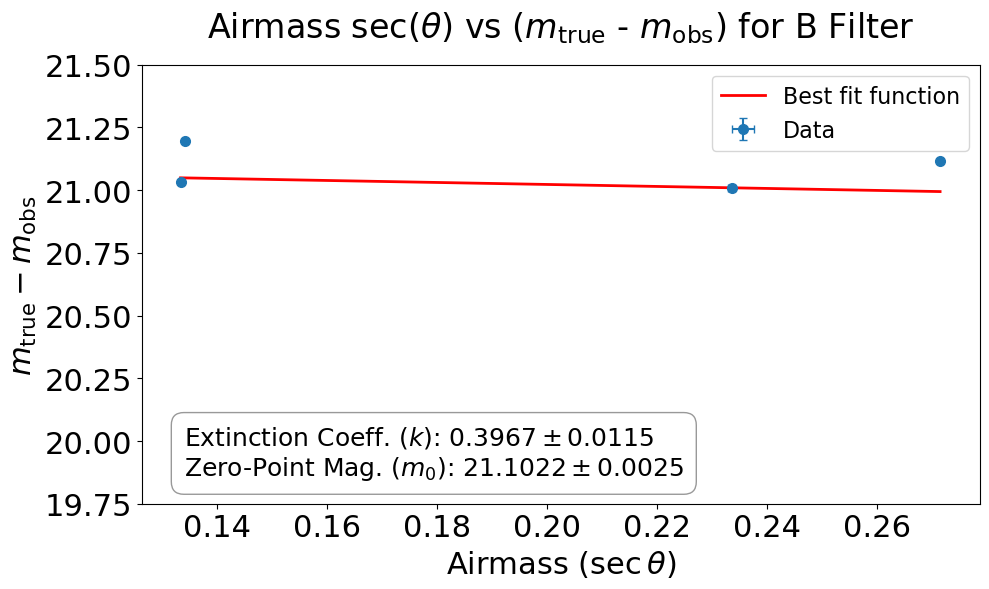

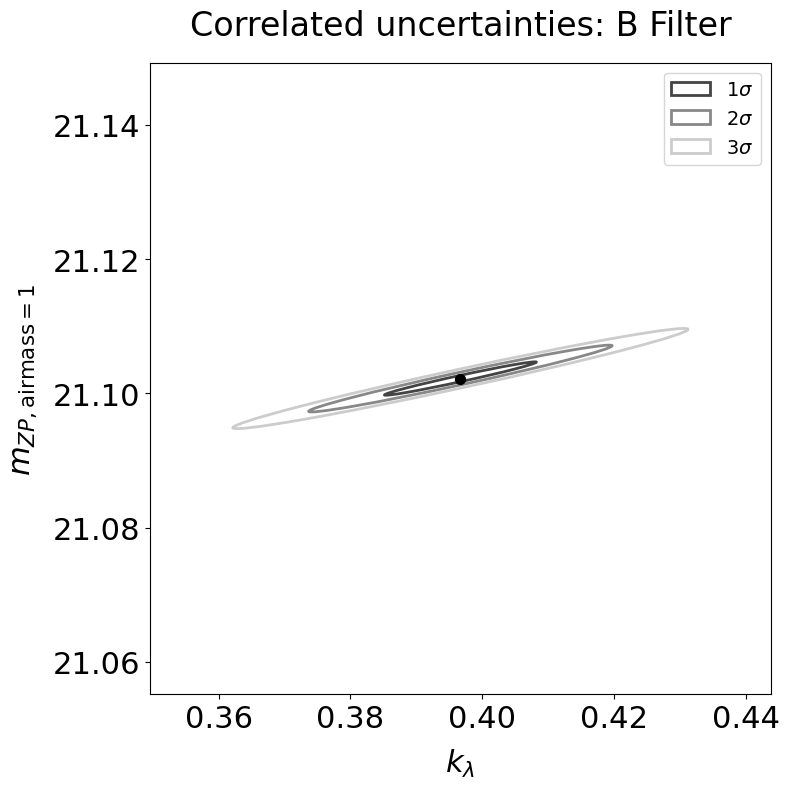

In [322]:
# set same_axis_scale=False for a zoomed in plot
# set yerr_best_fit=True to plot the best fit line using errors
k_B, k_B_err, m_zpt_B, m_zpt_B_err = perform_extinction_correction(mags_B, airmasses_B_corrected, ins_mags_err_B, airmasses_err_B,
                                                                   'B', print_text = True, same_axis_scale = True, yerr_best_fit = True,
                                                                  abs_sigma = True)

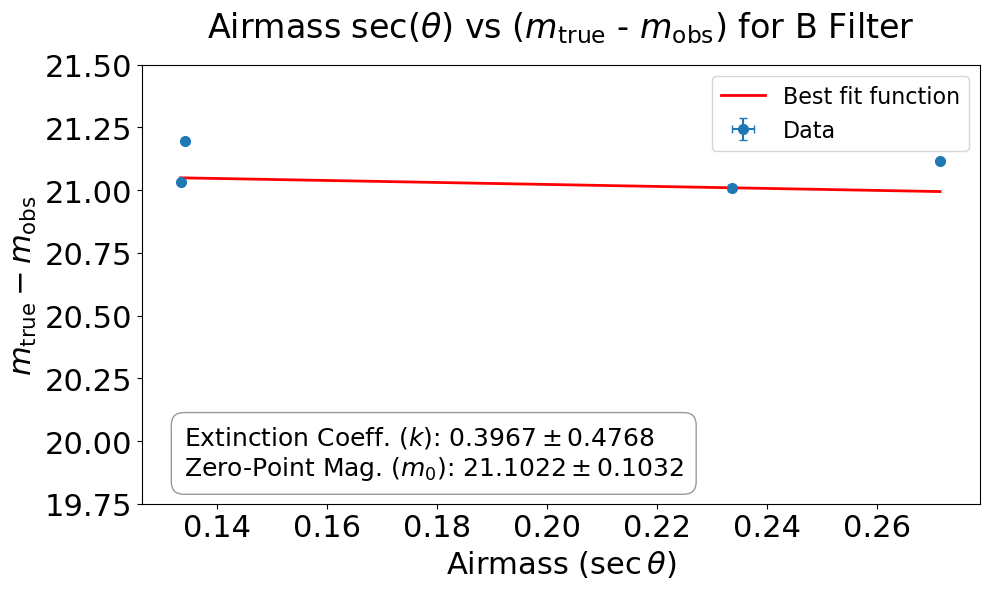

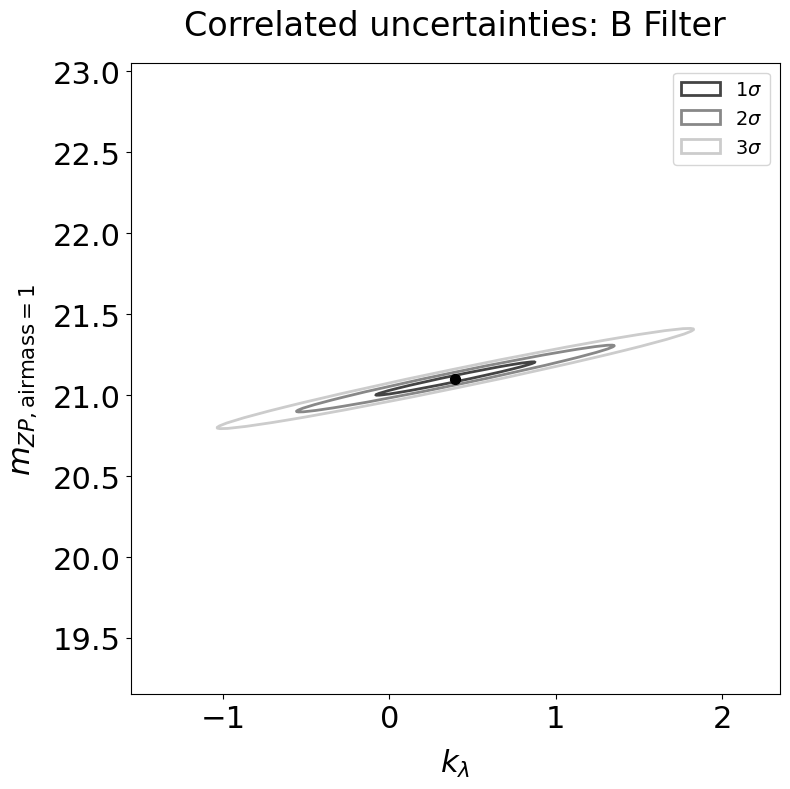

In [323]:
# set same_axis_scale=False for a zoomed in plot
# set yerr_best_fit=True to plot the best fit line using errors
k_B, k_B_err, m_zpt_B, m_zpt_B_err = perform_extinction_correction(mags_B, airmasses_B_corrected, ins_mags_err_B, airmasses_err_B,
                                                                   'B', print_text = True, same_axis_scale = True, yerr_best_fit = True,
                                                                  abs_sigma = False)

## I Filter

In [139]:
## using yerr_best_fit = True: 26
## using yerr_best_fit = False: 72

In [140]:
# plot for I filter

# set print_values=True to see all the values
ins_mags_I, ins_mags_err_I, airmasses_I, airmasses_err_I = filter_ins_mag_vs_airmass('I', print_values=False)
mags_I = np.array(stn_mags_I) - np.array(ins_mags_I)

# correct for airmass at 1 (not 0!)
airmasses_I_corrected = airmasses_I - np.ones(len(airmasses_I))

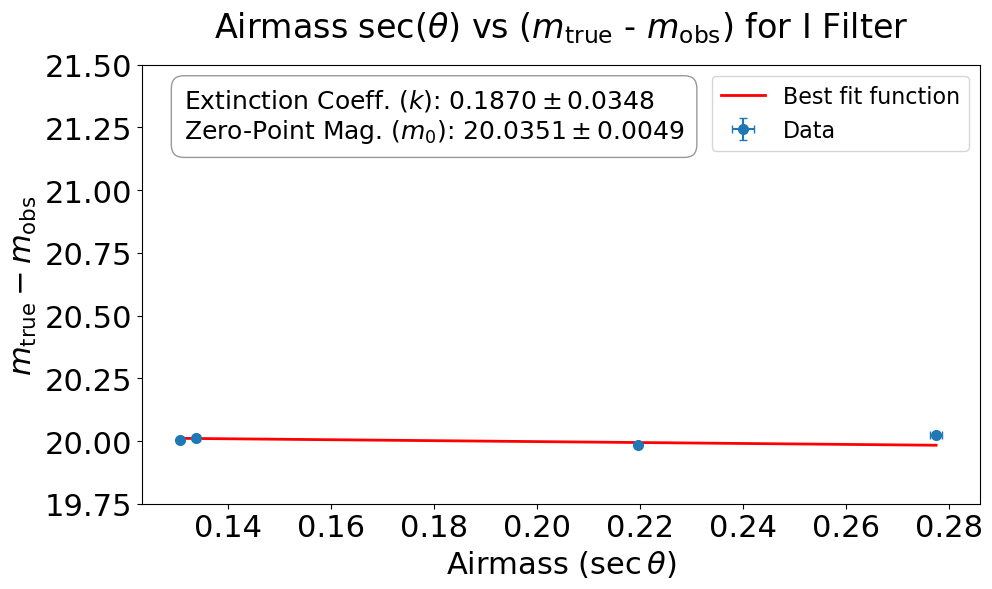

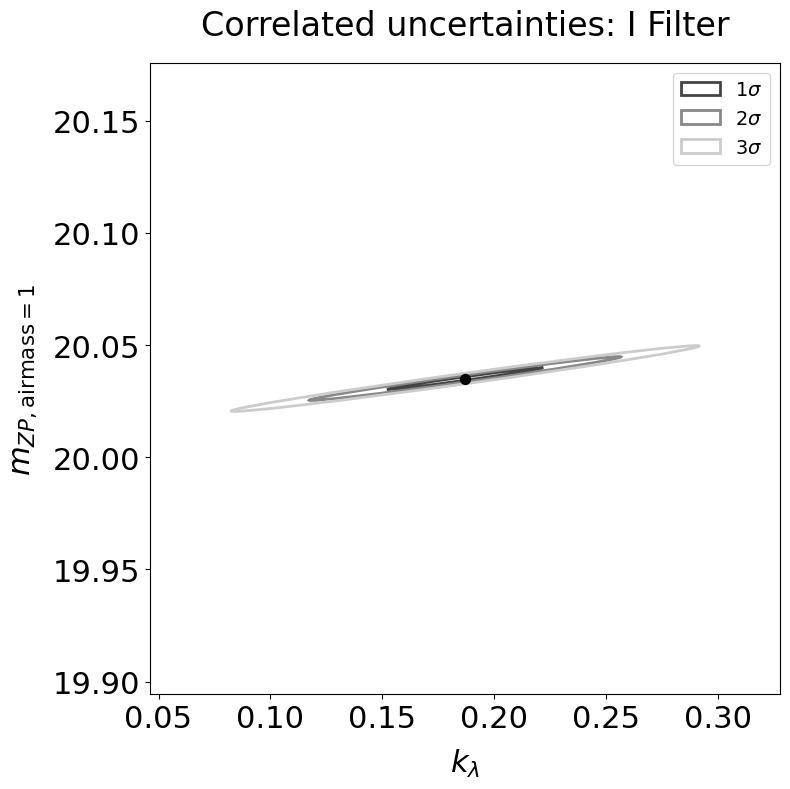

In [324]:
# set same_axis_scale=False for a zoomed in plot
# set yerr_best_fit=True to plot the best fit line using errors
k_I, k_I_err, m_zpt_I, m_zpt_I_err = perform_extinction_correction(mags_I, airmasses_I_corrected, ins_mags_err_I, airmasses_err_I,
                                                                   'I', print_text = True, same_axis_scale = True, yerr_best_fit = True,
                                                                  abs_sigma = True)

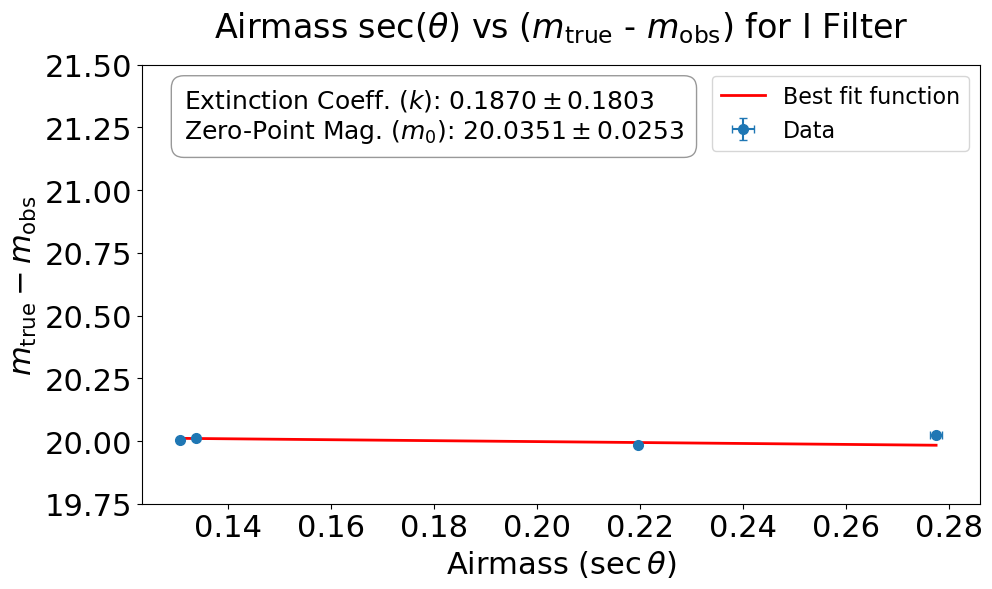

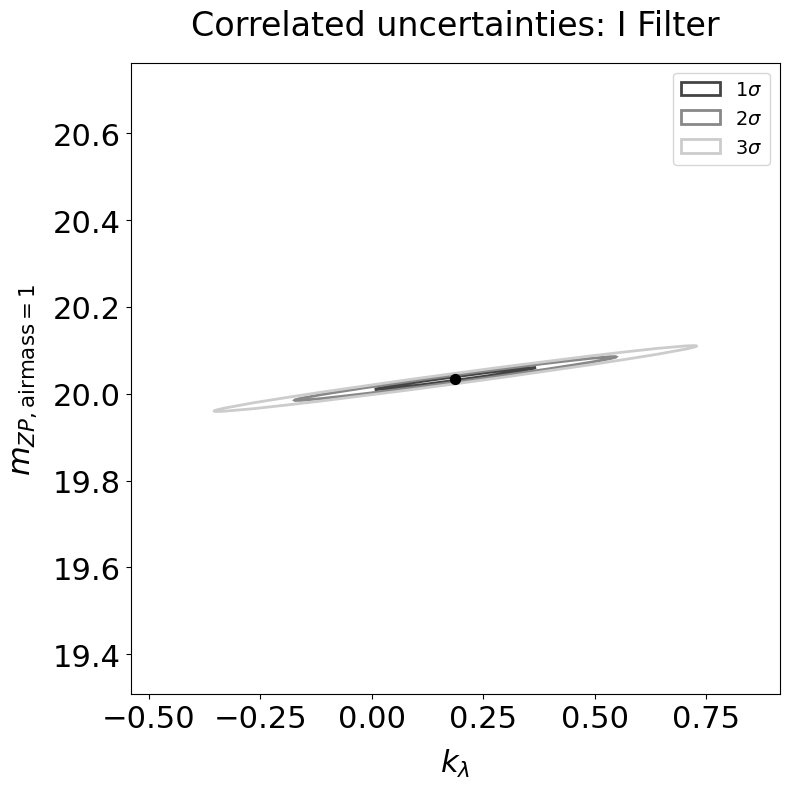

In [325]:
# set same_axis_scale=False for a zoomed in plot
# set yerr_best_fit=True to plot the best fit line using errors
k_I, k_I_err, m_zpt_I, m_zpt_I_err = perform_extinction_correction(mags_I, airmasses_I_corrected, ins_mags_err_I, airmasses_err_I,
                                                                   'I', print_text = True, same_axis_scale = True, yerr_best_fit = True,
                                                                  abs_sigma = False)

## R Filter

In [256]:
## using yerr_best_fit = True: 2354
## using yerr_best_fit = False: 2842

In [257]:
# plot for R filter

# set print_values=True to see all the values
ins_mags_R, ins_mags_err_R, airmasses_R, airmasses_err_R = filter_ins_mag_vs_airmass('R', print_values=False)
mags_R = np.array(stn_mags_R) - np.array(ins_mags_R)
#print(airmasses_R)

# correct for airmass at 1 (not 0!)
airmasses_R_corrected = airmasses_R - np.ones(len(airmasses_R))

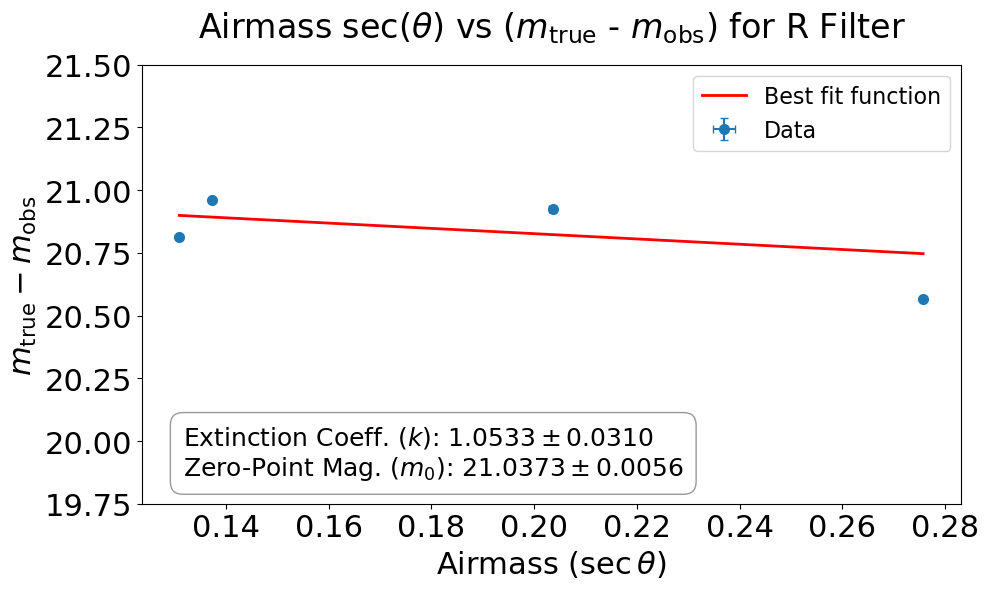

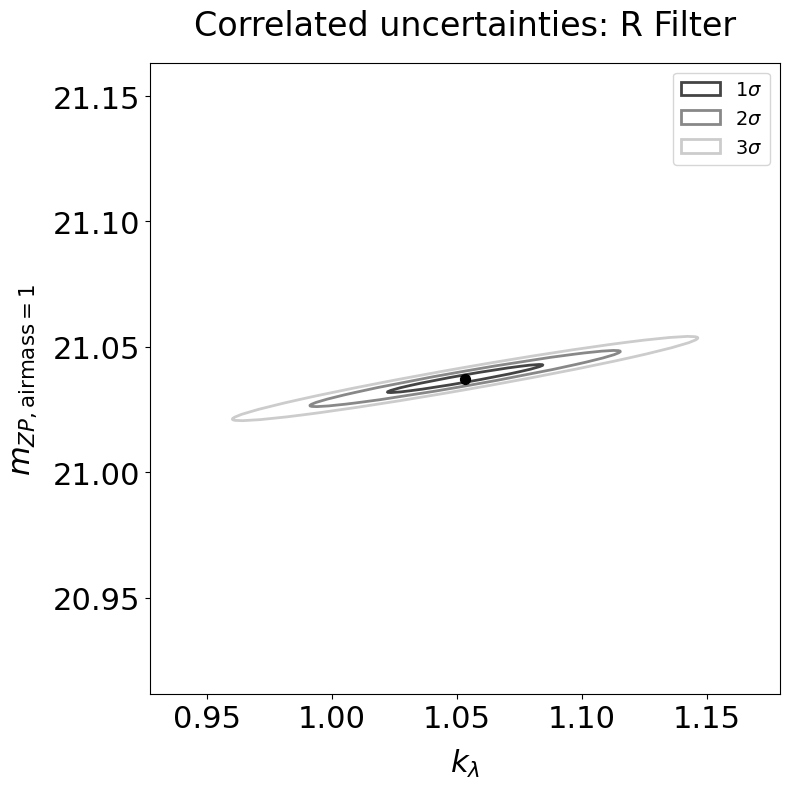

In [326]:
# set same_axis_scale=False for a zoomed in plot
# set yerr_best_fit=True to plot the best fit line using errors
k_R, k_R_err, m_zpt_R, m_zpt_R_err = perform_extinction_correction(mags_R, airmasses_R_corrected, ins_mags_err_R, airmasses_err_R, 
                                                                   'R', print_text = True, same_axis_scale = True, yerr_best_fit = True,
                                                                  abs_sigma = True)

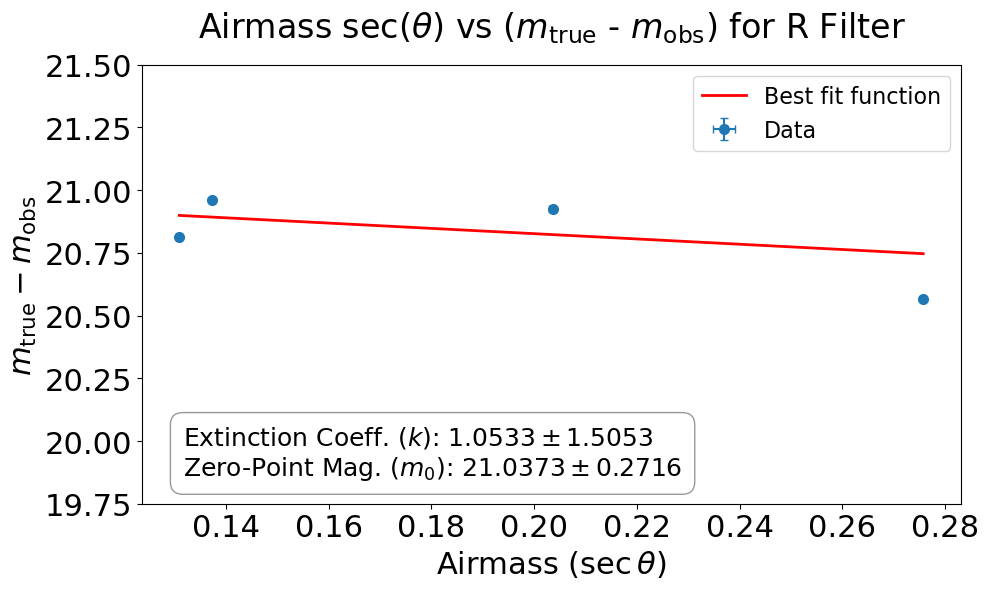

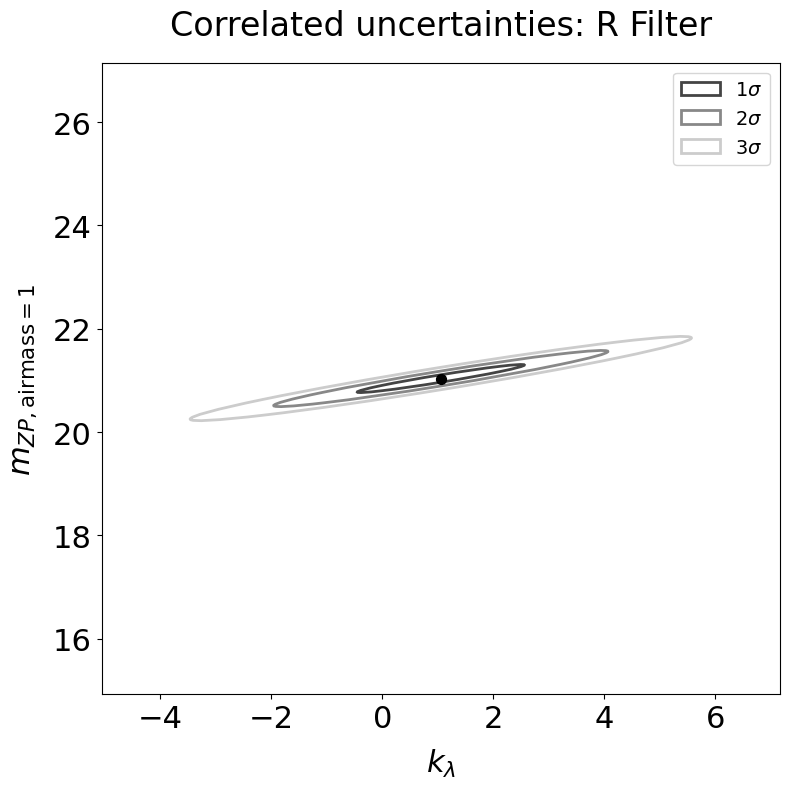

In [327]:
# set same_axis_scale=False for a zoomed in plot
# set yerr_best_fit=True to plot the best fit line using errors
k_R, k_R_err, m_zpt_R, m_zpt_R_err = perform_extinction_correction(mags_R, airmasses_R_corrected, ins_mags_err_R, airmasses_err_R, 
                                                                   'R', print_text = True, same_axis_scale = True, yerr_best_fit = True,
                                                                  abs_sigma = False)

## V Filter

In [260]:
## using yerr_best_fit = True: 1740
## using yerr_best_fit = False: 6651

In [261]:
# plot for V filter

# set print_values=True to see all the values
ins_mags_V, ins_mags_err_V, airmasses_V, airmasses_err_V = filter_ins_mag_vs_airmass('V', print_values=False)
mags_V = np.array(stn_mags_V) - np.array(ins_mags_V)

# correct for airmass at 1 (not 0!)
airmasses_V_corrected = airmasses_V - np.ones(len(airmasses_V))

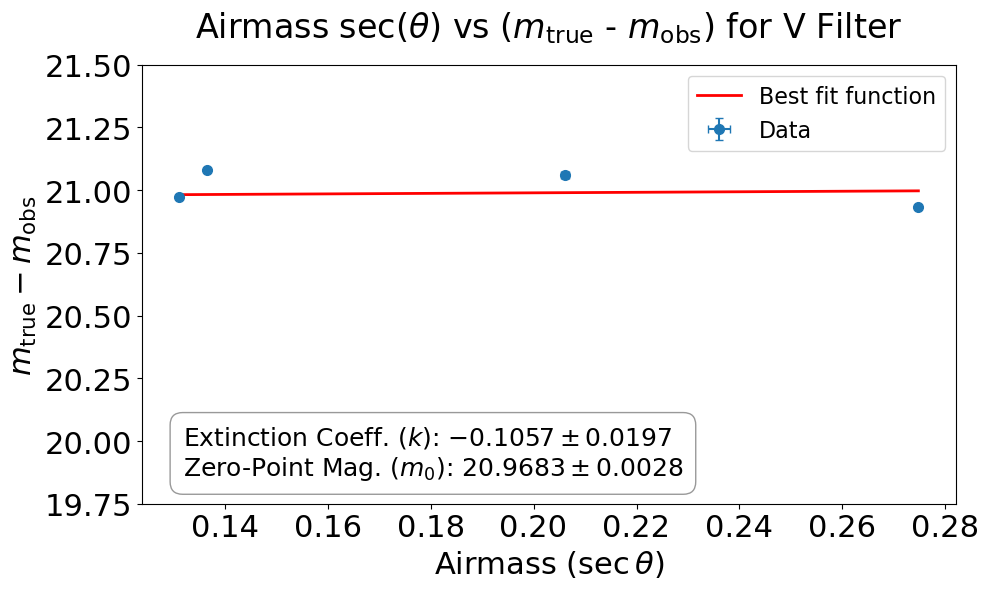

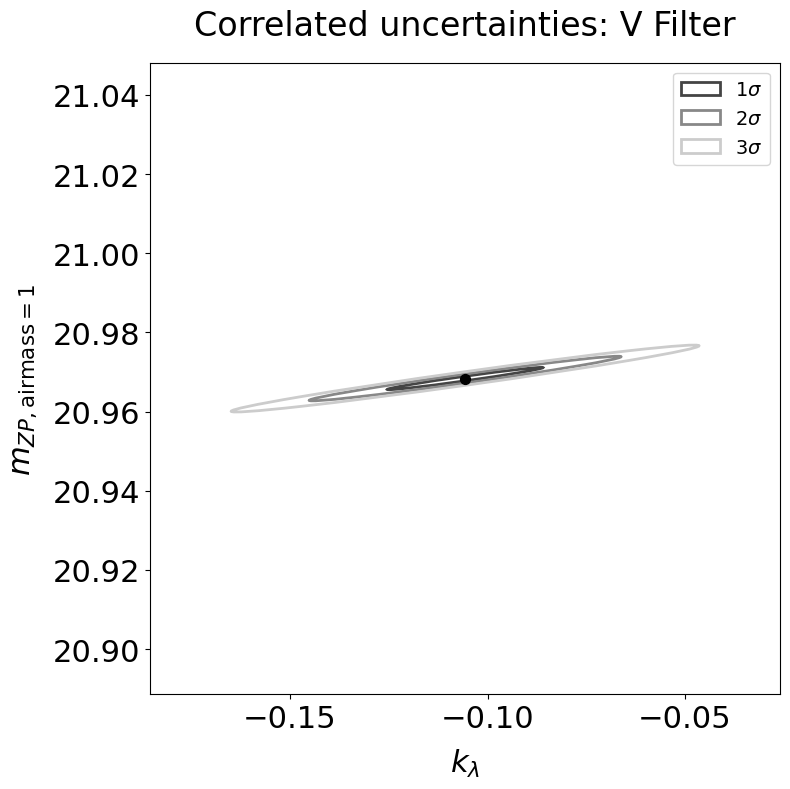

In [328]:
# set same_axis_scale=False for a zoomed in plot
# set yerr_best_fit=True to plot the best fit line using errors
k_V, k_V_err, m_zpt_V, m_zpt_V_err = perform_extinction_correction(mags_V, airmasses_V_corrected, ins_mags_err_V, airmasses_err_V,
                                                                   'V', print_text = True, same_axis_scale = True, yerr_best_fit = True,
                                                                  abs_sigma = True)


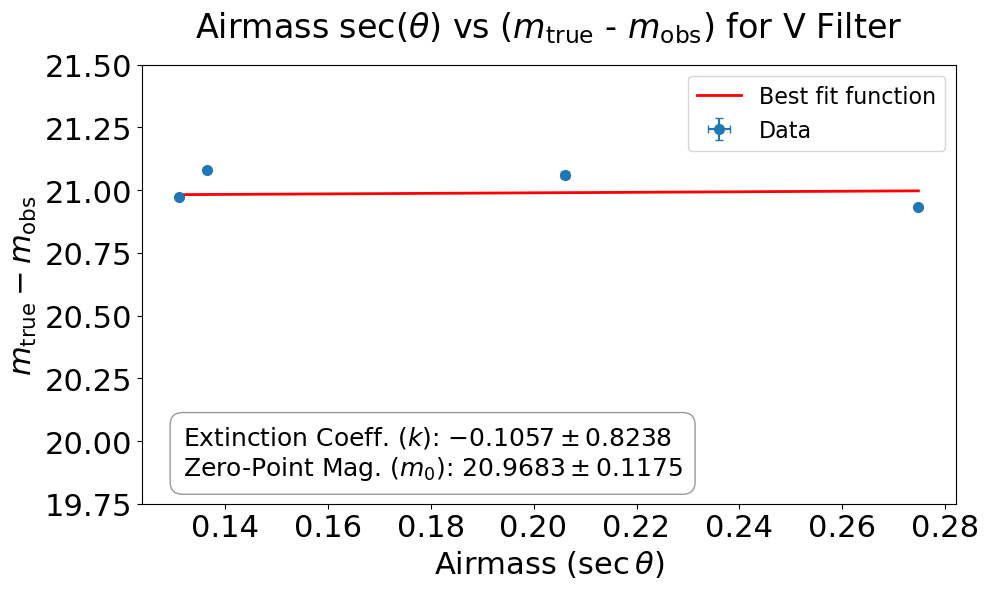

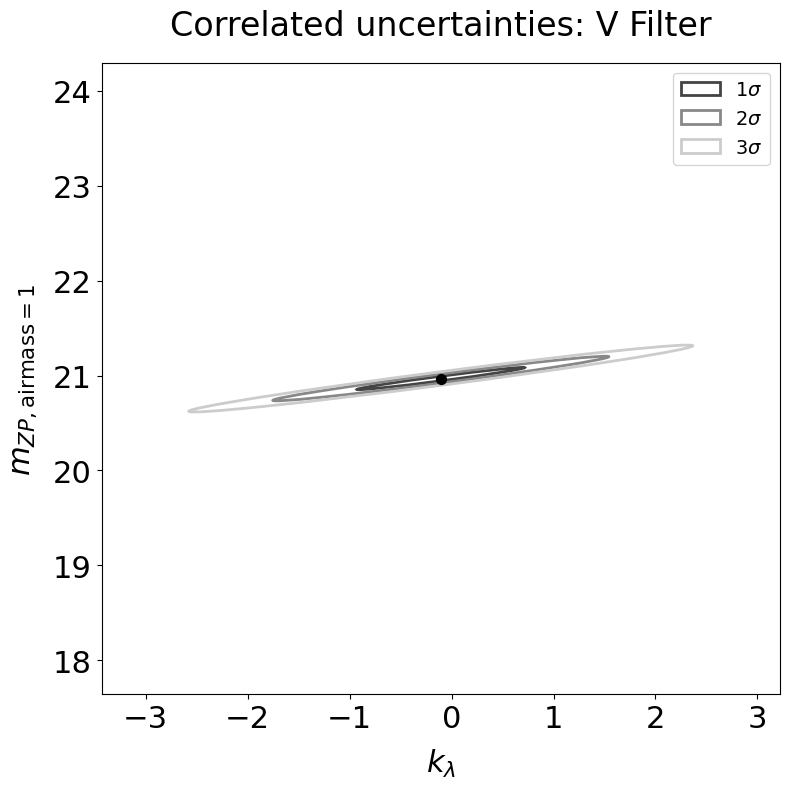

In [329]:
# set same_axis_scale=False for a zoomed in plot
# set yerr_best_fit=True to plot the best fit line using errors
k_V, k_V_err, m_zpt_V, m_zpt_V_err = perform_extinction_correction(mags_V, airmasses_V_corrected, ins_mags_err_V, airmasses_err_V,
                                                                   'V', print_text = True, same_axis_scale = True, yerr_best_fit = True,
                                                                  abs_sigma = False)


# Calculate the final calibrated magnitude of WASP-135b

In [264]:
#print(target_ins_mags)
#print(target_ins_mag_errs)
#print(target_airmasses)

In [265]:
# make empty lists to hold the values
target_ins_mag = []
target_ins_mag_err = []
target_airmass = []

## B Filter

In [266]:
def calculate_wasp_magnitude_error(inst_mag_err, airmass, airmass_err, k, k_err, zpt_err, filter):
    """
    Calculates the propagated error for target magnitude using linear extinction.
    
    Parameters:
    inst_mag_err (float/array): Error in instrumental magnitude
    airmass (float/array): The airmass (X)
    airmass_err (float/array): Error in airmass calculation
    k_v (float): Extinction coefficient
    k_v_err (float): Error in extinction coefficient
    zpt_err (float): Error in the zero point
    
    Returns:
    numpy.ndarray: The total propagated error for the target magnitude
    """
    # Ensure inputs are numpy arrays for element-wise math
    inst_mag_err = np.array(inst_mag_err)
    airmass = np.array(airmass)
    airmass_err = np.array(airmass_err)

    # Sum of squares of the individual error components
    error_squared = (
        inst_mag_err**2 + 
        (k * airmass_err)**2 + 
        (airmass * k_err)**2 + 
        zpt_err**2
    )

    final_err = np.sqrt(error_squared)

    #print(f"for filter {filter}")
    
    #print(f"instrumental magnitude error: {inst_mag_err}")
    
    #print(f"airmass ± error: {airmass} ± {airmass_err}")
    #print(f"extinction coefficient (k): {k} ± {k_err}")
    
    #print(f"k * airmass_err: {k * airmass_err}")
    #print(f"airmass * k_err: {airmass * k_err}")
    
    #print(f"zero-point error: {zpt_err}")
    #print(f"final error: {final_err}")
    
    return final_err

In [267]:
# B = 14.204

In [268]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter B

ins_mag_target_B, ins_mags_err_target_B, airmasses_target_B, airmasses_target_err_B = wasp_filter_ins_mag_vs_airmass('B', print_values=False)

# set print_values=True to print the values calculated
m_target_B = ins_mag_target_B - (np.ones(len(airmasses_target_B)) * k_B * airmasses_target_B) + m_zpt_B
#print(airmasses_target_B)
#print(k_B)

# correct for airmass at 1 (not 0!)
airmasses_target_B_corrected = airmasses_target_B - np.ones(len(airmasses_target_B))

m_target_B = ins_mag_target_B - (np.array(airmasses_target_B_corrected) * k_B) + m_zpt_B
m_target_B_err = calculate_wasp_magnitude_error(ins_mags_err_target_B, airmasses_target_B_corrected, airmasses_target_err_B, k_B, k_B_err, m_zpt_B_err, filter = "B")

print(f"{m_target_B} ± {m_target_B_err}")

[14.15577181] ± [0.17020355]


## V Filter

In [269]:
# V = 13.181 ± 0.080
# V = 13.28

In [270]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter V

# set print_values=True to print the values calculated
ins_mag_target_V, ins_mags_err_target_V, airmasses_target_V, airmasses_target_err_V = wasp_filter_ins_mag_vs_airmass('V', print_values=False)

#print(airmasses_target_V)
#print(k_V)

# correct for airmass at 1 (not 0!)
airmasses_target_V_corrected = airmasses_target_V - np.ones(len(airmasses_target_V))

m_target_V = ins_mag_target_V - (np.array(airmasses_target_V_corrected) * k_V) + m_zpt_V
m_target_V_err = calculate_wasp_magnitude_error(ins_mags_err_target_V, airmasses_target_V_corrected, airmasses_target_err_V, k_V, k_V_err, m_zpt_V_err, filter = "V")

print(f"{m_target_V} ± {m_target_V_err}")
print("Reduced chi squared: 1740.4148244693388")

[13.2360461] ± [0.24569741]
Reduced chi squared: 1740.4148244693388


## R Filter

In [271]:
# R = 12.98

In [272]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter R

# set print_values=True to print the values calculated
ins_mag_target_R, ins_mags_err_target_R, airmasses_target_R, airmasses_target_err_R = wasp_filter_ins_mag_vs_airmass('R', print_values=False)

m_target_R = ins_mag_target_R - (np.ones(len(airmasses_target_R)) * k_B * airmasses_target_R) + m_zpt_R

#print(airmasses_target_R)
#print(k_R)

# correct for airmass at 1 (not 0!)
airmasses_target_R_corrected = airmasses_target_R - np.ones(len(airmasses_target_R))

m_target_R = ins_mag_target_R - (np.array(airmasses_target_R_corrected) * k_R) + m_zpt_R
m_target_R_err = calculate_wasp_magnitude_error(ins_mags_err_target_R, airmasses_target_R_corrected, airmasses_target_err_R, k_R, k_R_err, m_zpt_R_err, filter = "R")

print(f"{m_target_R} ± {m_target_R_err}")
print("Reduced chi squared: 2354.937035829429")

[12.59794277] ± [0.45672176]
Reduced chi squared: 2354.937035829429


## I Filter

In [273]:
# I = 12.286

In [274]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter I

# set print_values=True to print the values calculated
ins_mag_target_I, ins_mags_err_target_I, airmasses_target_I, airmasses_target_err_I = wasp_filter_ins_mag_vs_airmass('I')

#print(airmasses_target_I)
#print(k_I)

# correct for airmass at 1 (not 0!)
airmasses_target_I_corrected = airmasses_target_I - np.ones(len(airmasses_target_I))

m_target_I = ins_mag_target_I - (np.array(airmasses_target_I_corrected) * k_I) + m_zpt_I
m_target_I_err = calculate_wasp_magnitude_error(ins_mags_err_target_I, airmasses_target_I_corrected, airmasses_target_err_I, k_I, k_I_err, m_zpt_I_err, filter = "I")

print(f"{m_target_I} ± {m_target_I_err}")
print("Reduced chi squared: 26.769014929942777")

[12.26717251] ± [0.04767274]
Reduced chi squared: 26.769014929942777


# Calculate the difference in colour magnitudes for WASP-135b

## B - V

In [275]:
# B-V = 0.97

In [276]:
B_V = m_target_B - m_target_V
B_V_err = np.sqrt(m_target_B_err**2 + m_target_V_err**2)
print(m_target_B, m_target_V) # my calculated values
print(14.25, 13.28) # true literature values
#print(m_target_B_err, m_target_V_err)
print(f"{B_V} ± {B_V_err}")

[14.15577181] [13.2360461]
14.25 13.28
[0.91972571] ± [0.29889206]


## V - R

In [277]:
V_R = m_target_V - m_target_R
V_R_err = np.sqrt(m_target_V_err**2 + m_target_R_err**2)
print(m_target_V, m_target_R) # my calculated values
print(13.28, 12.98) # true literature values
#print(m_target_V_err, m_target_R_err)
print(f"{V_R} ± {V_R_err}")

[13.2360461] [12.59794277]
13.28 12.98
[0.63810333] ± [0.51861545]


## R - I

In [278]:
R_I = m_target_R - m_target_I
R_I_err = np.sqrt(m_target_R_err**2 + m_target_I_err**2)
print(m_target_R, m_target_I) # my calculated values
print(12.98, 12.29) # true literature values
#print(m_target_R_err, m_target_I_err)
print(f"{R_I} ± {R_I_err}")

[12.59794277] [12.26717251]
12.98 12.29
[0.33077026] ± [0.45920307]


## V - I

In [300]:
V_I = m_target_V - m_target_I
V_I_err = np.sqrt(m_target_V_err**2 + m_target_I_err**2)
print(m_target_V, m_target_I) # my calculated values
print(13.28, 12.29) # true literature values
#print(m_target_V_err, m_target_I_err)
print(f"{V_I} ± {V_I_err}")

[13.2360461] [12.26717251]
13.28 12.29
[0.96887359] ± [0.25027965]


# Test data

In [279]:
V_mag = np.array([12.43, 13.38, 8.58, 8.91])
altitude = np.array([33.9, 74.2, 51.1, 43.7])
exp_time = np.array([30, 60, 10, 15])
counts = np.array([73980, 74820, 954928, 1047480])
counts_err = np.array([2714, 2059, 8702, 9620])

In [280]:
normalised_counts = counts / exp_time
normalised_counts_err = counts_err / exp_time

In [281]:
ins_mag = -2.5 * np.log10(normalised_counts)
print(ins_mag)

[ -8.47998268  -7.73966613 -12.44992657 -12.1101362 ]


In [282]:
ins_mag_err = - 2.5 / np.log(10) * (normalised_counts_err / normalised_counts)
print(ins_mag_err)

[-0.03983087 -0.02987879 -0.00989402 -0.00997134]


In [283]:
zenith_angle = 90 - altitude
zenith_angle_rad = np.deg2rad(zenith_angle)
airmass = 1.0 / np.cos(zenith_angle_rad)
print(airmass)

[1.7929337  1.03926554 1.28494546 1.44742431]


In [284]:
mags = V_mag - ins_mag
print(mags)

[20.90998268 21.11966613 21.02992657 21.0201362 ]


In [285]:
# correct for airmass at 1 (not 0!)
airmass_corrected = airmass - np.ones(len(airmass))

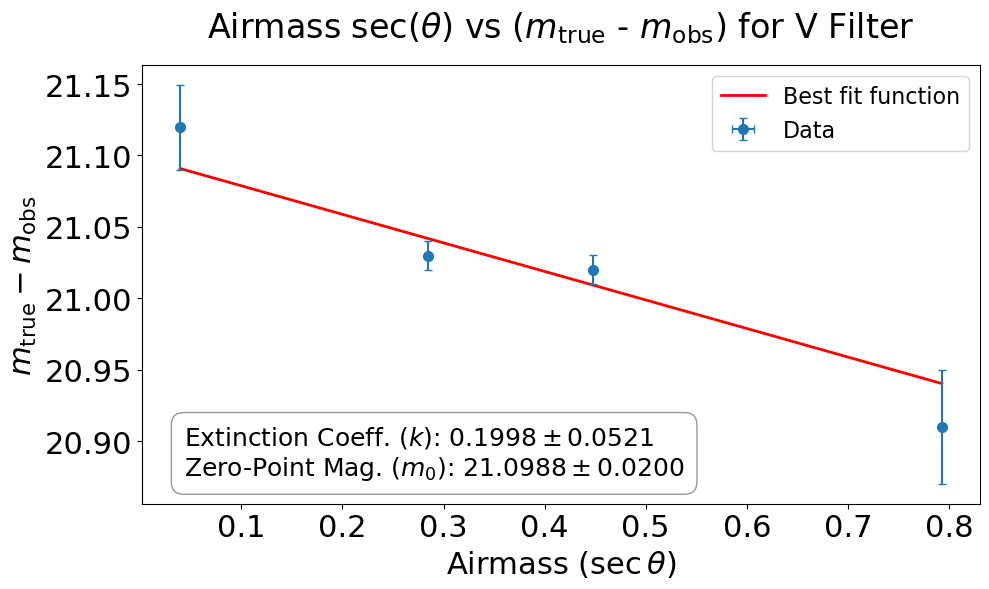

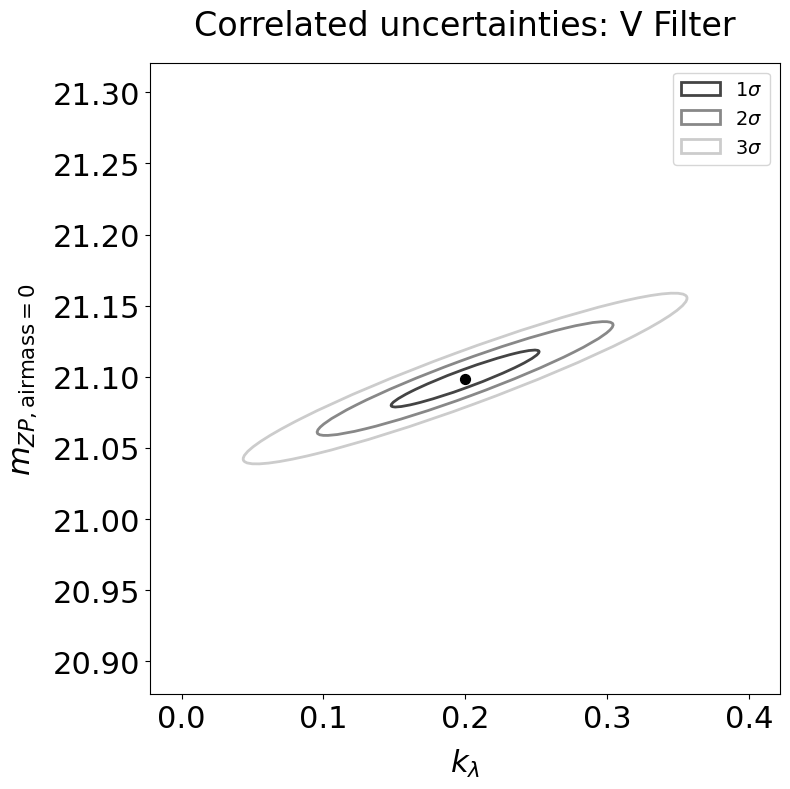

In [286]:
k, k_err, m_zpt, m_zpt_err = perform_extinction_correction(mags, airmass_corrected, ins_mag_err, np.array([0, 0, 0, 0]), filter_name = "V", print_text = True,
                             same_axis_scale = False, yerr_best_fit = True)

## target values
### zero-point magnitude at airmass 1: 21.10
### extinction coefficient: 0.21

## Interstellar Dust Extinction Correction

In [313]:
import pandas as pd
import numpy as np

"""
Intrinsic colours (B-V), (V-R)_C, (V-I)_C taken from your table screenshot.
We compute (R-I)_C = (V-I)_C - (V-R)_C to stay consistent.
"""
"""
data = {
    "spec type (V)": ["B0", "B2", "B5", "B8", "A0", "A2", "A5", "A8",
                      "F0", "F2", "F5", "F8", "G0", "G2", "G5", "G8",
                      "K0", "K2", "K5", "M0"],

    # (B-V) from fitzgerald 1970 "the intrinsic colour of stars and two colour reddening lines.
    "Intrinsic B-V": [-0.30, -0.24, -0.16, -0.11, -0.01, 0.05, 0.15, 0.27,
                      0.32, 0.35, 0.45, 0.53, 0.60, 0.63, 0.68, 0.74,
                      0.81, 0.92, 1.15, 1.37],

    # (V-R)_C from Ducati 2001 "intrinsic colours of stars in the near IR".
    "Intrinsic V-R": [-0.19, -0.14, -0.10, -0.08, -0.04, -0.01, 0.04, 0.09,
                      0.12, 0.15, 0.21, 0.24, 0.27, 0.30, 0.31, 0.35,
                      0.42, 0.50, 0.68, 0.70],

    # (V-I)_C from taking STScl 2002, "intrinsic colours as a function of spectral type" - website 
    "Intrinsic V-I": [-0.31, -0.29, -0.24, -0.16, -0.04, 0.00, 0.09, 0.20,
                      0.28, 0.35, 0.44, 0.50, 0.54, 0.58, 0.61, 0.66,
                      0.75, 0.89, 1.20, 1.67],
}"""
data = {
    "spec type (V)": ["B0", "B0.5", "B1", "B1.5", "B2", "B2.5", "B3", "B4", "B5", "B6", "B7", "B8", "B9", "B9.5",
                      "A0", "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9",
                      "F0", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9",
                      "G0", "G1", "G2", "G3", "G4", "G5", "G6", "G7", "G8", "G9",
                      "K0", "K1", "K2", "K3", "K4", "K5", "K6", "K7", "K8", "K9",
                      "M0", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"],
    
    # (B-V) from Pecaut & Mamajek 2013
    "Intrinsic B-V": [-0.307, -0.295, -0.278, -0.252, -0.210, -0.198, -0.178, -0.165, -0.156, -0.140, -0.128, -0.109, -0.070, -0.050,
                      0.000, 0.043, 0.074, 0.090, 0.140, 0.160, 0.170, 0.210, 0.250, 0.255,
                      0.294, 0.334, 0.374, 0.389, 0.412, 0.438, 0.484, 0.510, 0.530, 0.552,
                      0.588, 0.604, 0.650, 0.661, 0.674, 0.680, 0.704, 0.713, 0.737, 0.777,
                      0.816, 0.847, 0.893, 0.990, 1.100, 1.134, 1.257, 1.336, 1.382, 1.418,
                      1.431, 1.484, 1.500, 1.544, 1.661, 1.874, 2.000, 2.060, 2.130, 1.890],
    
    # (V-Rc) from Pecaut & Mamajek 2013
    "Intrinsic V-R": [-0.115, -0.115, -0.115, -0.114, -0.094, -0.087, -0.080, -0.074, -0.070, -0.062, -0.058, -0.048, -0.028, -0.017,
                      0.001, 0.019, 0.042, 0.050, 0.078, 0.089, 0.094, 0.117, 0.140, 0.143,
                      0.166, 0.190, 0.213, 0.222, 0.236, 0.252, 0.276, 0.290, 0.300, 0.312,
                      0.331, 0.340, 0.363, 0.368, 0.374, 0.377, 0.388, 0.393, 0.404, 0.423,
                      0.443, 0.460, 0.487, 0.544, 0.640, 0.671, 0.771, 0.824, 0.859, 0.900,
                      0.913, 0.974, 1.001, 1.079, 1.241, 1.446, 1.950, 2.180, 2.150, 1.890],
    
    # (V-Ic) from Pecaut & Mamajek 2013
    "Intrinsic V-I": [-0.325, -0.338, -0.325, -0.281, -0.230, -0.210, -0.192, -0.176, -0.165, -0.145, -0.133, -0.108, -0.061, -0.035,
                      0.004, 0.044, 0.091, 0.108, 0.164, 0.186, 0.197, 0.242, 0.288, 0.294,
                      0.339, 0.385, 0.432, 0.449, 0.476, 0.506, 0.553, 0.579, 0.599, 0.620,
                      0.656, 0.672, 0.713, 0.722, 0.733, 0.738, 0.758, 0.766, 0.786, 0.820,
                      0.853, 0.883, 0.929, 1.025, 1.190, 1.246, 1.448, 1.574, 1.671, 1.802,
                      1.848, 2.074, 2.173, 2.420, 2.831, 3.277, 4.100, 4.520, 4.600, 4.370],
}

"""
data = {
    "spec type (V)": [ "B5", "A5", 
                       "F5",   "G5", 
                       "K5", "M0"],

    # (B-V) from fitzgerald 1970 "the intrinsic colour of stars and two colour reddening lines.
    "Intrinsic B-V": [ -0.16,  0.15,
                       0.45,  0.68,
                        1.15, 1.37],

    # (V-R)_C from Ducati 2001 "intrinsic colours of stars in the near IR".
    "Intrinsic V-R": [ -0.10,  0.04, 
                      0.21,  0.31, 
                        0.68, 0.70],

    # (V-I)_C from taking STScl 2002, "intrinsic colours as a function of spectral type" - website 
    "Intrinsic V-I": [ -0.24,   0.09, 
                       0.44,   0.61, 
                      1.20, 1.67],
}
"""
df = pd.DataFrame(data)

# Compute (R-I)_C consistently from (V-I)_C - (V-R)_C
df["Intrinsic R-I"] = df["Intrinsic V-I"] - df["Intrinsic V-R"]


# Extinction assumptions

R_V = 3.1

# Your original B-band relation (same as you used):
c_B = 1 + 1 / R_V           # A_B/A_V

# Cardelli et al (1989), extinction law.
c_R = 0.751                 # A_R/A_V
c_I = 0.479                 # A_I/A_V

# Johnson-Cousins approximate values:
#c_B = 1.324  # A_B/A_V (you have this)
#c_V = 1.000  # A_V/A_V (by definition)
#c_R = 0.748  # A_R/A_V (check this - yours is 0.751, close)
#c_I = 0.482  # A_I/A_V (check this - yours is 0.479, close)


# Predict observed colours for each A_V

for A_V in A_V_array:
    tag = f"{A_V:.1f}"  # prevents column-name collisions

    # B-V = (B-V)0 + (A_B - A_V) = (B-V)0 + (c_B - 1) * A_V
    df[f"B-V_obs_Av{tag}"] = df["Intrinsic B-V"] + (c_B - 1) * A_V

    # V-R = (V-R)0 + (A_V - A_R) = (V-R)0 + (1 - c_R) * A_V
    df[f"V-R_obs_Av{tag}"] = df["Intrinsic V-R"] + (1 - c_R) * A_V

    # R-I = (R-I)0 + (A_R - A_I) = (R-I)0 + (c_R - c_I) * A_V
    df[f"R-I_obs_Av{tag}"] = df["Intrinsic R-I"] + (c_R - c_I) * A_V

print(df)


   spec type (V)  Intrinsic B-V  Intrinsic V-R  Intrinsic V-I  Intrinsic R-I  \
0             B0         -0.307         -0.115         -0.325         -0.210   
1           B0.5         -0.295         -0.115         -0.338         -0.223   
2             B1         -0.278         -0.115         -0.325         -0.210   
3           B1.5         -0.252         -0.114         -0.281         -0.167   
4             B2         -0.210         -0.094         -0.230         -0.136   
..           ...            ...            ...            ...            ...   
59            M5          1.874          1.446          3.277          1.831   
60            M6          2.000          1.950          4.100          2.150   
61            M7          2.060          2.180          4.520          2.340   
62            M8          2.130          2.150          4.600          2.450   
63            M9          1.890          1.890          4.370          2.480   

    B-V_obs_Av0.1  V-R_obs_Av0.1  R-I_o

### B-V = 0.97
### V-R = 0.30
### V-I = 0.99
### R-I = 0.69

In [314]:
obs = {
    "BV": 0.97,   # B-V
    "VR": 0.30,   # V-R
    "RI": 0.69   # R-I
}
sig = {
    "BV": 0.014,
    "VR": 0.014,
    "RI": 0.014
}
obs = {
    "BV": B_V,   # B-V
    "VR": V_R,   # V-R
    "RI": R_I   # R-I
}
sig = {
    "BV": B_V_err,
    "VR": V_R_err,
    "RI": R_I_err
}
obs = {
    "BV": B_V,   # B-V
    "VR": R_I,   # V-R
    "RI": V_R   # R-I
}
sig = {
    "BV": B_V_err,
    "VR": R_I_err,
    "RI": V_R_err
}
obs = {
    "BV": B_V,   # B-V
    "VI": V_I
}
sig = {
    "BV": B_V_err,
    "VI": V_R_err
}

Best-fit spectral type: K2
Best-fit A_V: 0.10
chi2_min: 0.15
Top 20 best-fit solutions (lowest chi2):
1) Spec type =         K2 | A_V = 0.10 | chi2 = 0.150
2) Spec type =         K1 | A_V = 0.20 | chi2 = 0.164
3) Spec type =         K1 | A_V = 0.10 | chi2 = 0.173
4) Spec type =         K0 | A_V = 0.30 | chi2 = 0.177
5) Spec type =         K0 | A_V = 0.20 | chi2 = 0.180
6) Spec type =         K2 | A_V = 0.20 | chi2 = 0.184
7) Spec type =         K1 | A_V = 0.30 | chi2 = 0.190
8) Spec type =         G9 | A_V = 0.40 | chi2 = 0.197
9) Spec type =         G9 | A_V = 0.30 | chi2 = 0.201
10) Spec type =         K0 | A_V = 0.40 | chi2 = 0.209
11) Spec type =         G8 | A_V = 0.50 | chi2 = 0.216
12) Spec type =         K0 | A_V = 0.10 | chi2 = 0.219
13) Spec type =         G8 | A_V = 0.40 | chi2 = 0.221
14) Spec type =         G7 | A_V = 0.50 | chi2 = 0.228
15) Spec type =         G9 | A_V = 0.50 | chi2 = 0.228
16) Spec type =         G7 | A_V = 0.60 | chi2 = 0.236
17) Spec type =         G6 

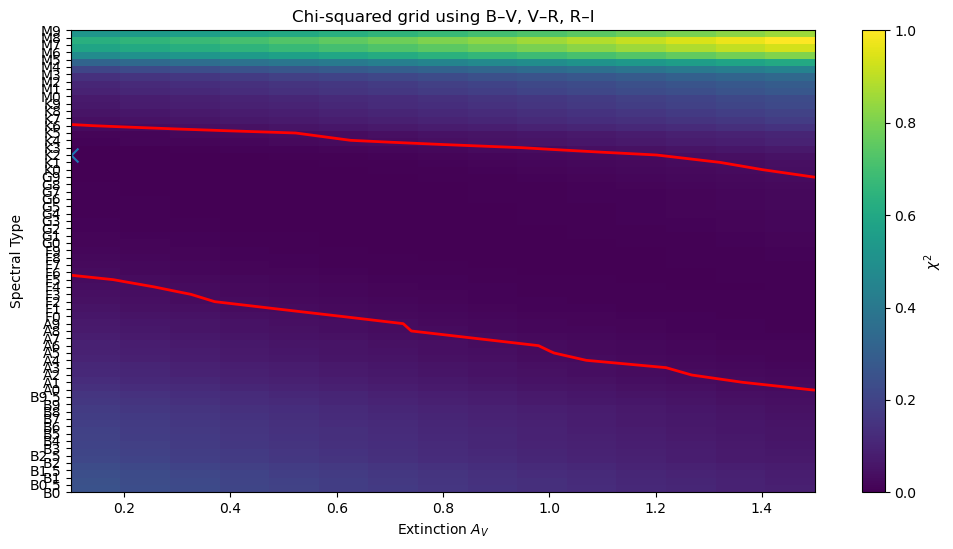

In [315]:
import matplotlib.pyplot as plt

spec_labels = df["spec type (V)"].values
spec_index  = np.arange(len(spec_labels))

# Make sure A_V_array is a numpy array for vector ops
A_V = np.array(A_V_array, dtype=float)

# --- Observed colours and uncertainties (from your worksheet) ---
"""
obs = {
    "BV": 1.01708771,   # B-V
    "VR": 0.69193948,   # V-R
    "RI": 0.23974876   # R-I
}
sig = {
    "BV": 0.3586723,
    "VR": 0.42972026,
    "RI": 0.37960278
}
"""
sig = {
    "BV": B_V_err,
    "VR": V_R_err,
    "RI": R_I_err
}
obs = {
    "BV": B_V,   # B-V
    "VR": V_R,   # V-R
    "RI": R_I   # R-I
}

# --- Extinction coefficients (Rv=3.1) ---
# You already have c_B = A_B/A_V
# And we used these for Cousins R and I:
# c_R = A_R/A_V, c_I = A_I/A_V
# (Keep the values consistent with your earlier code)
#c_R = 0.751
#c_I = 0.479

# --- Initialise chi2 grid: rows=spectral types, cols=A_V values ---
chi2 = np.zeros((len(spec_labels), len(A_V)), dtype=float)

for i in range(len(spec_labels)):

    BV0 = df.loc[i, "Intrinsic B-V"] #locate each value i under "intrinsic B-V in data frame.
    VR0 = df.loc[i, "Intrinsic V-R"]
    RI0 = df.loc[i, "Intrinsic R-I"]
    VI0 = df.loc[i, "Intrinsic V-I"]

    # Model predictions for each A_V 
    BV_model = BV0 + (c_B - 1) * A_V # BV_obs = BV_true + Colour excess
    VR_model = VR0 + (1 - c_R) * A_V  # takes entire array of colour at given spectral type and multiples that with given Av (2D matrix).        
    RI_model = RI0 + (c_R - c_I) * A_V
    VI_model = VI0 + (1 - c_I) * A_V

    # Chi^2 summed across colours
    chi2[i, :] = ( # [i, :] for a given spec type calculate chi2 for all Av
        ((obs["BV"] - BV_model) ** 2) / (sig["BV"] ** 2) +  #[ χ²(i, Av0), χ²(i, Av1), χ²(i, Av2), ... ]
        ((obs["VR"] - VR_model) ** 2) / (sig["VR"] ** 2) +  # chi2 sum is over 3 colours 
        ((obs["RI"] - RI_model) ** 2) / (sig["RI"] ** 2)
    )

    # Chi^2 summed across colours
    #chi2[i, :] = ( # [i, :] for a given spec type calculate chi2 for all Av
    #    ((obs["BV"] - BV_model) ** 2) / (sig["BV"] ** 2) +  #[ χ²(i, Av0), χ²(i, Av1), χ²(i, Av2), ... ]
    #    ((obs["VI"] - VI_model) ** 2) / (sig["VI"] ** 2) 
    #)
   



# Best fit
imin, jmin = np.unravel_index(np.argmin(chi2) , chi2.shape) 
"""
1) argmin returns smallest chi2 value in entire grid - but it does it along an axis - returns 1 single number.
2) unravel_index takes that index and tells us where in the 2D array that is 
3) chi2.shape specifies what shape to unravel the index back into.
"""


"""
# d.o.f = N_colours - N_parameters = 4(BVRI)-2(Spectype, A_V)
# more colours - the tighter we can constrain the model. chi2min becomes sharper, contour region shrinks, best fit more unique. 
# more colours - more information - more data points. reduce system error (bias in one band).
"""

chi2_min = chi2[imin, jmin]                  
best_type = spec_labels[imin]
best_Av = A_V[jmin]

print(f"Best-fit spectral type: {best_type}")
print(f"Best-fit A_V: {best_Av:.2f}")
print(f"chi2_min: {chi2_min:.2f}")

# 1-sigma region for TWO fitted parameters (spectral type + A_V): delta chi2 = 2.30

flat_idx = np.argsort(chi2.ravel())[:20]   # indices of 5 smallest chi2 values
i20, j20 = np.unravel_index(flat_idx, chi2.shape)

print("Top 20 best-fit solutions (lowest chi2):")
for rank, (i, j) in enumerate(zip(i20, j20), start=1):
    print(
        f"{rank}) Spec type = {spec_labels[i]:>10s} | "
        f"A_V = {A_V[j]:.2f} | "
        f"chi2 = {chi2[i, j]:.3f}"
    )

"""
contour - how far away can my chi2 value be to be statistically significant?
"""

chi2_cont = chi2_min + 2.3 # "the min chi2 method - NASA/IPAC intergalactic database

# Plot
plt.figure(figsize=(12,6))
plt.imshow(
    chi2,
    aspect="auto",
    origin="lower", # default starts topleft so spec type would be inverted of labels.
    cmap="viridis",                 # array is 0-19 so len = 20 and -1 = 19
    extent=[A_V.min(), A_V.max(), 0, len(spec_index)-1] # x axis - A_Vmin/max (actual A_V values0 0, len(spec_index)-1 - yaxis 
)

CS = plt.contour(
    A_V,
    spec_index,
    chi2,
    levels=[chi2_cont],
    colors="red",
    linewidths=2
)

plt.scatter([best_Av], [imin], marker="x", s=100)  # mark best-fit

plt.yticks(spec_index, spec_labels) # at these indicies label them with the strings "spec_labels"
plt.xlabel("Extinction $A_V$")
plt.ylabel("Spectral Type")
plt.colorbar(label= "$\chi^2$")
plt.title("Chi-squared grid using B–V, V–R, R–I")
plt.show()


# look up reduced chi2 - should be same as chi2 anyway as 1 d.o.f.
